
    
# ST2195 Programming for Data Science

    
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)




## Coursework Project



> Python (3.8.12) 


## Table of content
1. [Introduction](#1.-Introduction)
2. [Data reading and Cleaning](#2.-Data-reading-and-Cleaning)
3. [EDA:](#3.-EDA)
4. [Questions:](#4.-Questions)
    + 4.1 [When is the best time of day, day of the week, and time of year to fly to minimise delays?](#Question-4.1.1)
        + 4.1.1 [When is the day of the week to fly to minimise delays?](#Question-4.1.1)
        + 4.1.2 [When is the best time of day to minimise delays?](#Question-4.1.2)
        + 4.1.3 [When is the best time of year to fly to minimise delays?](#Question-4.1.3)
    + 4.2 [Do older planes suffer more delays?](#Question-4.2)
    + 4.3 [How does the number of people flying between different locations change over time?](#Question-4.3)
    + 4.4 [Can you detect cascading failures as delays in one airport create delays in others?](#Question-4.4)
    + 4.5 [Use the available variables to construct a model that predicts delays.](#Question-4.5)
5. [Summary](#5.-Summary)


# 1. Introduction

Dataset reference: The 2009 ASA Statistical Computing and Graphics Data Expo https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/HG7NV7


# 2. Data reading and Cleaning

In [1]:
#import librarys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
import dataframe_image as dfi
from functools import reduce #
from datetime import datetime, timedelta
from scipy.stats import chi2_contingency
from functools import reduce #import reduce from functools


In [2]:
#read data
airports = pd.read_csv("airports.csv") #airport variables
carriers = pd.read_csv("carriers.csv") #carrier variables
airplanes = pd.read_csv("plane-data.csv") #airplane variables

df1 = pd.read_csv("2006.csv") #import data for year 2006
df2 = pd.read_csv("2007.csv") #import data for year 2007
df3 = pd.read_csv("2008.csv") #import data for year 2008

In [3]:
#see and compare data shape
print(df1.shape) #year 2006
print(df2.shape) #year 2007
print(df3.shape) #year 2008

(7141922, 29)
(7453215, 29)
(2389217, 29)


In [4]:
#check for missing datapoints in 2008.csv (due to the small size compared to other years)
df3['Month'].value_counts() 

3    616090
1    605765
4    598126
2    569236
Name: Month, dtype: int64

In [5]:
#year 2008 only has month up to april, so we don't use it.

#check for NA's for 2006 and 2007
print(df1.isna().sum())
print(df2.isna().sum())

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime               121934
CRSDepTime                 0
ArrTime               138120
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum                    0
ActualElapsedTime     138120
CRSElapsedTime             4
AirTime               138120
ArrDelay              138120
DepDelay              121934
Origin                     0
Dest                       0
Distance                   0
TaxiIn                     0
TaxiOut                    0
Cancelled                  0
CancellationCode     7019988
Diverted                   0
CarrierDelay               0
WeatherDelay               0
NASDelay                   0
SecurityDelay              0
LateAircraftDelay          0
dtype: int64
Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime               160748
C

If we adress NA's now, i it could potentially lead to loss of important datapoints. Let's instead try to see if there is a rational explanation for some of theese, i.e. if a flight is cancelled, then any delay entry shouldn't be possible. 

<AxesSubplot:>

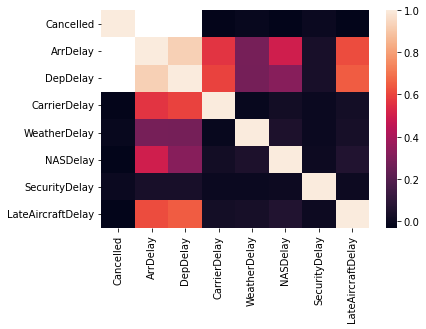

In [6]:
#check for correlation between cancalation and delays 

#merge dataframes for 2006 and 2007
cancel_org = pd.concat([df1, df2],ignore_index=True) #we can also use to verify NA's later.

#select columns of interest
cancel=cancel_org[['Cancelled','CancellationCode','ArrDelay','DepDelay','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']]

#correlation heatmap (check how cancelations are correlated to delays)
cancel_heatm = sns.heatmap(cancel.corr()) #plot the heatmap
cancel_heatm
#cancel_heatm.figure.savefig("clean_plot1.png") #save to img

In [7]:
#the heatmap suggest a very strong correlation

#narrow in on the issue
cancel2 = cancel[['Cancelled','CancellationCode','ArrDelay','DepDelay']]
cancel2=cancel2[cancel2['Cancelled']==1] #  select only cancelled flights

#explore cancelation data
print(cancel2)
print(cancel2.isna().sum()) #sum of NA's

          Cancelled CancellationCode  ArrDelay  DepDelay
11                1                A       NaN       NaN
52                1                C       NaN       NaN
70                1                C       NaN       NaN
74                1                C       NaN       NaN
99                1                C       NaN       NaN
...             ...              ...       ...       ...
14595045          1                B       NaN       NaN
14595046          1                B       NaN       NaN
14595052          1                B       NaN       NaN
14595053          1                B       NaN       NaN
14595121          1                B       NaN       NaN

[282682 rows x 4 columns]
Cancelled                0
CancellationCode         0
ArrDelay            282682
DepDelay            282682
dtype: int64


As we suspected, if a flight is cancelled then there is no delay entry (in fact: delay NA's = row count in df). Hence we should only select data without cancelled flights. 

In [8]:
#dataframes without cancelled flights.
df1=df1[df1['Cancelled']==0] 
df2=df2[df2['Cancelled']==0] 

#Similarly if a plane is diverted, then arrival delay entry should be impossible.
#remaining NA values corresponds to diverted in the same way as cancelled.
print(df1.ArrDelay.isna().sum()) #sum of NA's
print(df1.DepDelay.isna().sum()) #sum of NA's
print(df2.ArrDelay.isna().sum()) #sum of NA's
print(df2.DepDelay.isna().sum()) #sum of NA's

16186
0
17179
0


<AxesSubplot:>

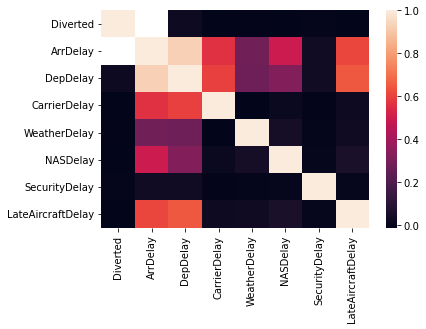

In [9]:
#heatmap of correlation between diverted and delays

#columns of interest
diverted=cancel_org[['Diverted','CancellationCode','ArrDelay','DepDelay','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']]

#correlation heatmap
diverted_heatm = sns.heatmap(diverted.corr()) #plot the heatmap
diverted_heatm
#diverted_heatm.figure.savefig("clean_plot2.png") #save to img

In [10]:
#again we see a very strong correlation. so we select non-diverted flights.

#dataframes without diverted flights.
df1=df1[df1['Diverted']==0] 
df2=df2[df2['Diverted']==0] 

#if our assumption regarding diverted is true, NA's should excluded from ArrDelay and DepDelay
print(df1.ArrDelay.isna().sum()) #sum of NA's
print(df1.DepDelay.isna().sum()) #sum of NA's
print(df2.DepDelay.isna().sum()) #sum of NA's
print(df2.ArrDelay.isna().sum()) #sum of NA's

0
0
0
0


In [11]:
#see shape of data
print(df1.shape)
print(df2.shape)

(7003802, 29)
(7275288, 29)


In [12]:
#to avoid any potential bias towards one year, we take sample to match datapoints
df2 = df2.sample(7003802)

In [13]:
#merge data (exclude 2008 to avoid bias towards the first 4 months)
df = pd.concat([df1, df2],ignore_index=True)

#verify that missing values in cancelled is taken care of
print(df['Cancelled'].sum())

#test against original data
print(cancel_org['Cancelled'].sum())

0
282682


In [14]:
#explore the data
df 

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2006,1,11,3,743.0,745,1024.0,1018,US,343,...,45,13,0,NaN,0,0,0,0,0,0
1,2006,1,11,3,1053.0,1053,1313.0,1318,US,613,...,27,19,0,NaN,0,0,0,0,0,0
2,2006,1,11,3,1915.0,1915,2110.0,2133,US,617,...,4,11,0,NaN,0,0,0,0,0,0
3,2006,1,11,3,1753.0,1755,1925.0,1933,US,300,...,16,10,0,NaN,0,0,0,0,0,0
4,2006,1,11,3,824.0,832,1015.0,1015,US,765,...,27,12,0,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14007599,2007,3,23,5,935.0,930,1051.0,1055,9E,5756,...,4,13,0,NaN,0,0,0,0,0,0
14007600,2007,12,15,6,1918.0,1915,2225.0,2155,WN,3232,...,7,40,0,NaN,0,0,0,30,0,0
14007601,2007,10,10,3,801.0,755,924.0,925,XE,7756,...,4,17,0,NaN,0,0,0,0,0,0
14007602,2007,12,24,1,1130.0,1125,1305.0,1305,WN,1522,...,7,7,0,NaN,0,0,0,0,0,0


In [15]:
#merge df with carrier variables to get names of airlines
df = pd.merge(df, carriers,  how='inner', left_on=['UniqueCarrier'], right_on = ['Code'])

#rename Description column to Carrier
df.rename(columns={'Description': 'Carrier'}, inplace=True)

#create columns
df['delay'] = ((df['DepDelay'])+(df['ArrDelay'])) #total delay column for a flight (Departure + Arrival delay)
df['dep_hour_standard'] = df['DepTime']/100*1.0386100 #departure standard time column
df['Date']= pd.to_datetime(pd.DataFrame({'year':df['Year'],
                                         'month':df['Month'],'day':df['DayofMonth'], 
                                         'hour':df['dep_hour_standard']})) #date column

df['dep_hour_int'] = (df['DepTime']/100).astype(int) #departure time column (in integer)
df['Date_bin']= pd.to_datetime(pd.DataFrame({'year':df['Year'],
                                             'month':df['Month'],'day':df['DayofMonth'], 
                                             'hour':df['dep_hour_int']})) #date column in bins

df.head() #explore new columns

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,NASDelay,SecurityDelay,LateAircraftDelay,Code,Carrier,delay,dep_hour_standard,Date,dep_hour_int,Date_bin
0,2006,1,11,3,743.0,745,1024.0,1018,US,343,...,0,0,0,US,US Airways Inc.,4.0,7.716872,2006-01-11 07:43:00.740280,7,2006-01-11 07:00:00
1,2006,1,11,3,1053.0,1053,1313.0,1318,US,613,...,0,0,0,US,US Airways Inc.,-5.0,10.936563,2006-01-11 10:56:11.627880,10,2006-01-11 10:00:00
2,2006,1,11,3,1915.0,1915,2110.0,2133,US,617,...,0,0,0,US,US Airways Inc.,-23.0,19.889381,2006-01-11 19:53:21.773400,19,2006-01-11 19:00:00
3,2006,1,11,3,1753.0,1755,1925.0,1933,US,300,...,0,0,0,US,US Airways Inc.,-10.0,18.206833,2006-01-11 18:12:24.599880,17,2006-01-11 17:00:00
4,2006,1,11,3,824.0,832,1015.0,1015,US,765,...,0,0,0,US,US Airways Inc.,-8.0,8.558146,2006-01-11 08:33:29.327040,8,2006-01-11 08:00:00


# 3. EDA

In [16]:
#details of delay related columns
del_info = df[['ArrDelay','DepDelay','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay',
               'LateAircraftDelay','delay']] #select columns
del_info.rename(columns={'ArrDelay': 'Arrival delay', 'DepDelay': 'Departure Delay',
                         'CarrierDelay':'Carrier Delay','WeatherDelay':'Weather Delay',
                         'NASDelay': 'NAS Delay', 'SecurityDelay': 'Security Delay',
                         'LateAircraftDelay':'Late Aircraft Delay',
                         'delay':'Total Delay'}, inplace=True) #rename columns
del_info = del_info.describe().T #describe and transpose delay information

#export to image 
del_info_style = del_info.style.format("{:.12}").background_gradient() #style table
dfi.export(del_info_style,"EDA_table1.png") #export to img
del_info_style

C:\Users\e2u\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,count,mean,std,min,25%,50%,75%,max
Arrival delay,14007604.0,9.44092765615,37.9851044114,-592.0,-9.0,-1.0,13.0,2598.0
Departure Delay,14007604.0,10.7127158221,34.7757936178,-1200.0,-4.0,0.0,10.0,2601.0
Carrier Delay,14007604.0,3.7124069898,20.0757984464,0.0,0.0,0.0,0.0,2580.0
Weather Delay,14007604.0,0.741176078364,9.17072270731,0.0,0.0,0.0,0.0,1429.0
NAS Delay,14007604.0,3.76740476101,16.0751211202,0.0,0.0,0.0,0.0,1392.0
Security Delay,14007604.0,0.027943251394,1.19842947292,0.0,0.0,0.0,0.0,382.0
Late Aircraft Delay,14007604.0,4.91507034322,20.8009429358,0.0,0.0,0.0,0.0,1366.0
Total Delay,14007604.0,20.1536434782,71.3996103799,-1196.0,-12.0,-1.0,22.0,5199.0


In [17]:
#explore departure delays (i.e. outlier, etc.)
print(df["DepDelay"][(df["DepDelay"] <0)].count())
print(df["DepDelay"][(df["DepDelay"] < -1000)].count())
print(df["DepDelay"][(df["DepDelay"] >2000)].count())

#explore arrival delays
print(df["ArrDelay"][(df["ArrDelay"] <0)].count())
print(df["ArrDelay"][(df["ArrDelay"] < -400)].count())
print(df["ArrDelay"][(df["ArrDelay"] >2000)].count())

6727459
42
1
7054628
12
1


In [18]:
#explore departure and arrival max outliers
exp_del = df[['Carrier','TailNum','DepDelay','ArrDelay']]
exp_del = exp_del[(exp_del["ArrDelay"] >2000) & (exp_del["DepDelay"] >2000)]

#export outlier table
exp_del_style = exp_del.style.format("{:.12}").background_gradient() #style table
dfi.export(exp_del_style,"EDA_table1_2.png") #export to img
exp_del_style 

,Carrier,TailNum,DepDelay,ArrDelay
10862909,Northwest Ai,N329NW,2601.0,2598.0


#### Percentage of all delays


In [19]:
#total no. of flights ontime, and delayed
delay_perc = (df['delay']<=0) #true: before or ontime, false: delayed
delay_perc.value_counts() #count

True     7472748
False    6534856
Name: delay, dtype: int64

In [20]:
#manual math cell: percentage of delayed flights
tot_flights = (6534546+7473058)
del_flights = 6534546
ont_flights = 7473058
perc=del_flights/tot_flights
perc2=ont_flights/tot_flights
print("Percentage of flights that are delayed: {:.00%}".format(perc))
print("Percentage of flights that are ontime: {:.00%}".format(perc2))

Percentage of flights that are delayed: 47%
Percentage of flights that are ontime: 53%


In [21]:
#change the total delay threshold to 10 minutes:
delay_perc2 = (df['delay']<=10) #10 min delay or less.
delay_perc2.value_counts() #count

True     9335733
False    4671871
Name: delay, dtype: int64

In [22]:
#manual math cell: percentage of delayed flights (10min  threshold)
tot_flights = (4671113+9336491)
del_flights = 4671113
ont_flights = 9336491
perc=del_flights/tot_flights
perc2=ont_flights/tot_flights
print("Percentage of flights that are delayed: {:.00%} - (10min threshold)".format(perc))
print("Percentage of flights that are ontime: {:.00%} - (10min threshold)".format(perc2))

Percentage of flights that are delayed: 33% - (10min threshold)
Percentage of flights that are ontime: 67% - (10min threshold)


In [23]:
#set plotting style for notebook
sns.reset_orig()
plt.style.use('seaborn-colorblind')
sns.set_style("whitegrid")

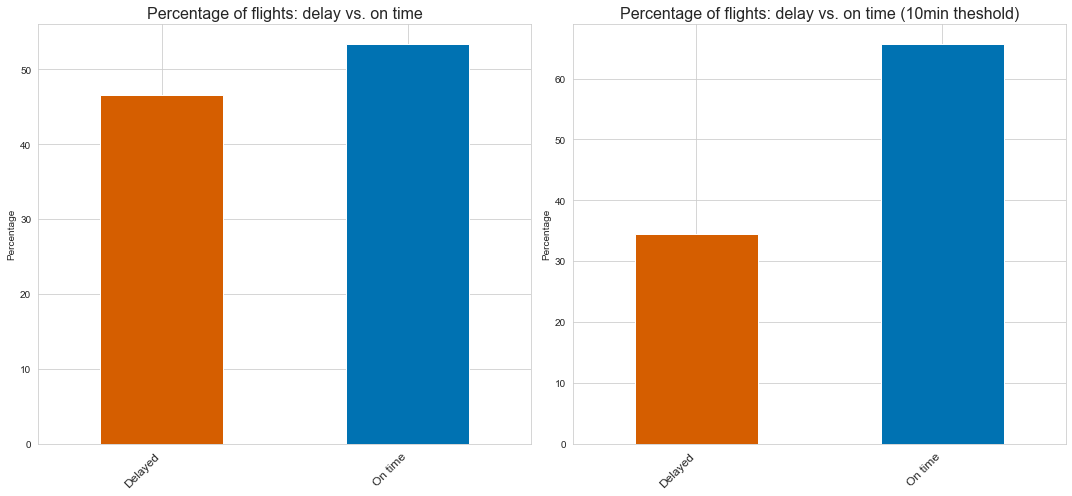

In [24]:
#plot delays

#data prep for plot
#percentage of delays converted to true/false values
delay_perc_plot = pd.DataFrame() #empty df
delay_perc_plot['Status']=df['delay']<=0 #column with delay status
for col in delay_perc_plot.columns[delay_perc_plot.dtypes == 'bool']:
    delay_perc_plot['Status'] = delay_perc_plot['Status'].map({True: 'On time', False: 'Delayed'}) #convert to boolean

#percentage of delays with a 10 min threshold (true/false)
delay_perc_plot_10 = pd.DataFrame() #cempty df
delay_perc_plot_10['Status_10min_int']=df['delay']<10 #10min threshold
for col in delay_perc_plot_10.columns[delay_perc_plot_10.dtypes == 'bool']:
    delay_perc_plot_10['Status_10min_int'] = delay_perc_plot_10['Status_10min_int'].map({True: 'On time', False: 'Delayed'}) #convert to boolean


#combined plot
f, ax = plt.subplots(1,2,figsize=(15, 7))

palette=['C2','C0'] #set colour

(delay_perc_plot['Status'].value_counts(normalize=True)*100).sort_values().plot(kind = 'bar', ax=ax[0], color=palette) #plot in percentage
(delay_perc_plot_10['Status_10min_int'].value_counts(normalize=True)*100).sort_values().plot(kind = 'bar', ax=ax[1], color=palette) #plot in percentage
#set labels
ax[0].set_title("Percentage of flights: delay vs. on time",fontsize = 16) #title ax0
plt.setp(ax[0].get_xticklabels(), rotation=45, ha='right',fontsize = 12) #rotate ax0
ax[0].set(ylabel="Percentage")
ax[1].set_title("Percentage of flights: delay vs. on time (10min theshold)",fontsize = 16) #title ax1
plt.setp(ax[1].get_xticklabels(), rotation=45, ha='right',fontsize = 12) #rotate ax1
ax[1].set(ylabel="Percentage")
plt.tight_layout() #tight layout
plt.style.use('seaborn-colorblind')
plt.show() #plot

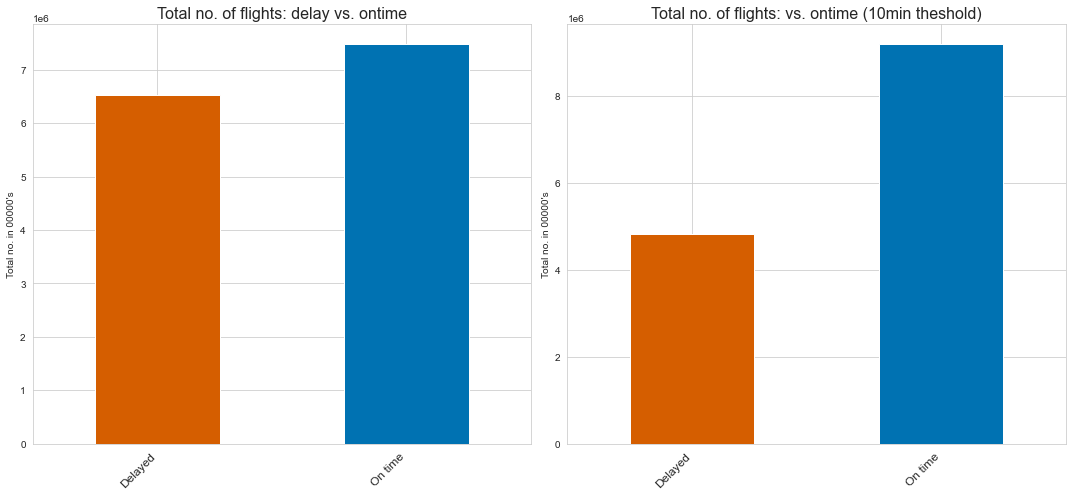

In [25]:
#plot delays (total)

#data prep for plot
#total delay converted to true/false values
delay_tot_plot = pd.DataFrame() #empty df
delay_tot_plot['Status']=df['delay']<=0 #0 min threshold
for col in delay_tot_plot.columns[delay_tot_plot.dtypes == 'bool']:
    delay_tot_plot['Status'] = delay_tot_plot['Status'].map({True: 'On time', False: 'Delayed'}) #convert to boolean

#total delay 10min threshold
delay_tot_plot_10 = pd.DataFrame() #empty df
delay_tot_plot_10['Status_10min_int']=df['delay']<10 #10 min threshold
for col in delay_tot_plot_10.columns[delay_tot_plot_10.dtypes == 'bool']:
    delay_tot_plot_10['Status_10min_int'] = delay_tot_plot_10['Status_10min_int'].map({True: 'On time', False: 'Delayed'})

#plot of total delays
f, ax = plt.subplots(1,2,figsize=(15, 7))

palette=['C2','C0'] #color

(delay_tot_plot['Status'].value_counts()).sort_values().plot(kind = 'bar', ax=ax[0], color=palette)
(delay_tot_plot_10['Status_10min_int'].value_counts()).sort_values().plot(kind = 'bar', ax=ax[1], color=palette)

#set labels
ax[0].set_title("Total no. of flights: delay vs. ontime",fontsize = 16) #title ax0
plt.setp(ax[0].get_xticklabels(), rotation=45, ha='right',fontsize = 12) #rotate ax0
ax[1].set_title("Total no. of flights: vs. ontime (10min theshold)",fontsize = 16) #title ax1
plt.setp(ax[1].get_xticklabels(), rotation=45, ha='right',fontsize = 12) #rotate ax1
plt.setp(ax, ylabel="Total no. in 00000's") #common y label.
plt.tight_layout() #tight layout
plt.show() #plot

In [26]:
#value count of both delay df's
print(delay_tot_plot.value_counts())
print(delay_tot_plot_10.value_counts())

Status 
On time    7472748
Delayed    6534856
dtype: int64
Status_10min_int
On time             9189644
Delayed             4817960
dtype: int64


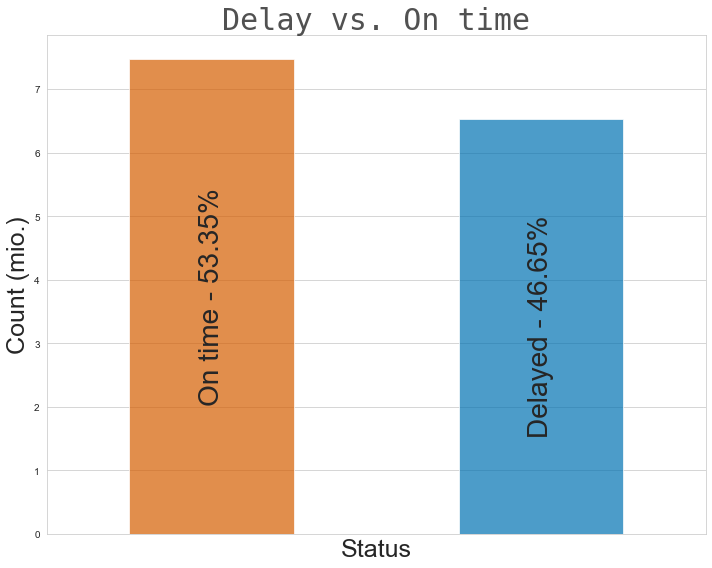

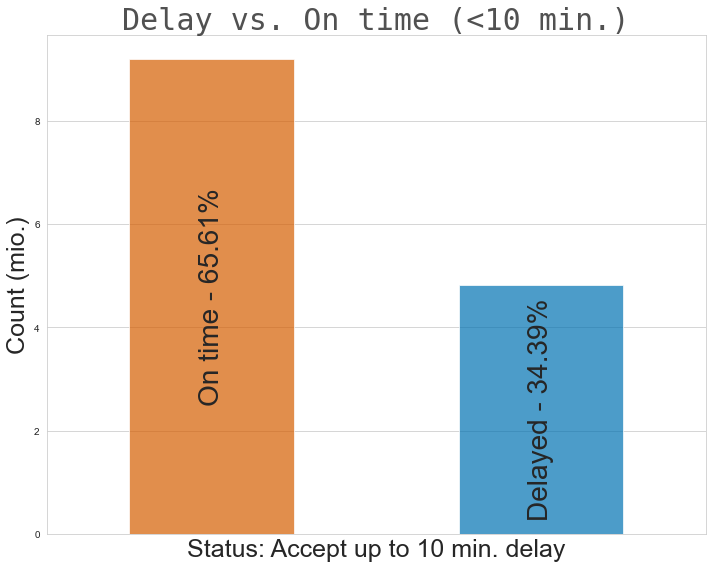

In [27]:
#merge and prettify the plots above

#plot data preparation
delay_dec_data=[7.473081,6.534523] #totals divided with 1000: fit plot to graph
delay_dec = pd.Series(index = ["On time", "Delayed"], data=delay_dec_data) #create series
percentage = delay_dec.div(delay_dec.sum()).mul(100).round(2) #calc. the percentage

#barplot with total and percentage in a combined plot (0 min threshold)
ax = delay_dec.plot(kind="bar", alpha=0.7, figsize=(10, 8), color=palette)

#set labels inside the bars
labels = [f'{delay_dec} - {percentage[delay_dec]}%' for delay_dec in delay_dec.index]
for label, a in zip(labels, ax.patches):
    left, bottom, width, height = a.get_bbox().bounds
    ax.annotate(label, xy=(left+width/2, bottom+height/2), ha='center', va='center', rotation=90, fontsize=28)
#labels
plt.ylabel("Count (mio.)", fontsize=25) #ylabel
plt.xlabel("Status", fontsize=25) #xlabel
plt.title("Delay vs. On time", fontsize=30, fontname="Monospace", alpha=.8) #title
plt.xticks([]) #empty xticks
plt.tight_layout(rect=[0, 0, 1, 1]) #tight layout (rectangular)
plt.savefig('EDA_plot1.png', bbox_inches='tight') #save img
plt.show()

#barplot with total and percentange in combined plot (10 min threshold)
delay_dec_data2=[9.190188,4.817416] #totals divided with 1000: to fit plot to graph
delay_dec2 = pd.Series(index = ["On time", "Delayed"], data=delay_dec_data2) #series
percentage2 = delay_dec2.div(delay_dec.sum()).mul(100).round(2) #calculate percent

#plot pretty bar for 10min threshold
ax = delay_dec2.plot(kind="bar",  alpha=0.7, figsize=(10, 8), color=palette)

#bar labels
labels = [f'{delay_dec2} - {percentage2[delay_dec2]}%' for delay_dec2 in delay_dec2.index]
for label, a in zip(labels, ax.patches):
    left, bottom, width, height = a.get_bbox().bounds
    ax.annotate(label, xy=(left+width/2, bottom+height/2), ha='center', va='center', rotation=90, fontsize=28)
#labels
plt.ylabel("Count (mio.)", fontsize=25) #ylabel
plt.xlabel("Status: Accept up to 10 min. delay", fontsize=25) #xlabel
plt.title("Delay vs. On time (<10 min.)", fontsize=30, fontname="Monospace", alpha=.8) #title
plt.xticks([]) #empty xticks
plt.tight_layout(rect=[0, 0, 1, 1]) #tight layout
plt.savefig('EDA_plot2.png', bbox_inches='tight') #save img
plt.show()

#### On time vs. delayed for each carrier 

C:\Users\e2u\AppData\Local\Temp/ipykernel_28964/3729033357.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) #yticks in percentage


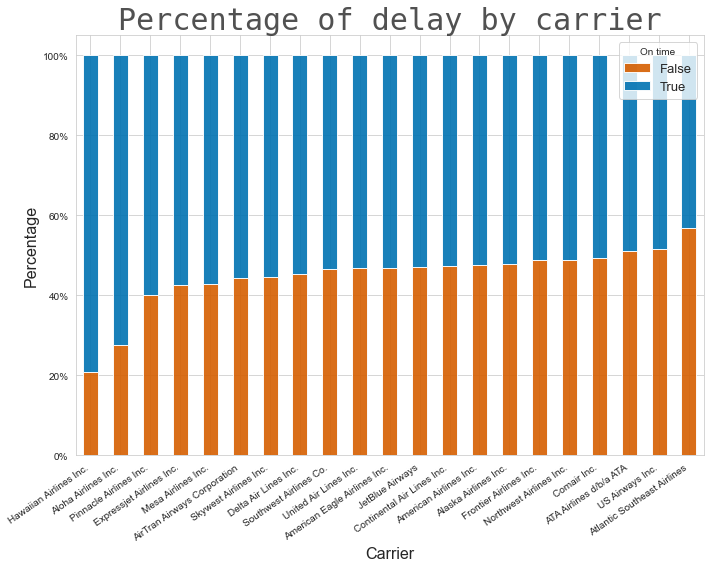

In [28]:
#plot of delay for each carrier (stacked barchart)

#data prep for plot
carier_delay_perc_plot = pd.DataFrame() #empty df
carier_delay_perc_plot['Carrier']=df['Carrier'] #carrier variable with full names
carier_delay_perc_plot['ontime']=df['delay']<=0 #on time vs. delay
carier_delay_perc_plot = carier_delay_perc_plot.groupby(['Carrier',
                                                           'ontime']).size().unstack(1) #shape and class data
carier_delay_perc_plot = carier_delay_perc_plot.div(carier_delay_perc_plot.sum(axis=1), axis=0) #percentage

#plot
f, ax = plt.subplots(figsize=(10, 8))
carier_delay_perc_plot.sort_values(by=False).plot(kind="bar", 
                                                  alpha=.9, stacked=True, ax=ax,color = palette) #stacked bar plot
#set labels
ax.set_title("Percentage of delay by carrier",fontsize = 30, fontname="Monospace", alpha=.8) #title
plt.xlabel('Carrier', fontsize = 16) #xlabel
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right") #rotate xlabel
plt.ylabel("Percentage", fontsize = 16) #ylabel
ax.legend(loc='upper right', title='On time', fontsize = 13)
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) #yticks in percentage
plt.tight_layout(rect=[0, 0, 1, 1]) #tight rectangular layout
plt.savefig('EDA_plot3.png', bbox_inches='tight') #save img
plt.show() #plot

The percentage of delay by carrier could perhaps be somewhat misleading (i.e. Hawaiian Airlines most on time flights, but surely a carrier like Delta or SouthWest Airlines must have more flights!) Let's explore the data a little further:


In [29]:
#create carrier total flights df
delay_carrier=df[['Carrier']].groupby("Carrier").count() #carrier column and group by count
delay_carrier['fligts']=df['Carrier'].value_counts() #total flights
delay_carrier = delay_carrier.reset_index(drop=False) #reset index

#carrier total delays df
delay_carrier2=(df[df['delay']>0]['Carrier'].value_counts()) #delayed
delay_carrier2=delay_carrier2.to_frame(name=('total delays')) #to df
delay_carrier2.index.name='Carrier' #set index name
delay_carrier2=delay_carrier2.reset_index(drop=False) #reset index

#merge to carrier delay df
delay_merge = delay_carrier.merge(delay_carrier2[['Carrier','total delays']],
                                  how='left',left_on='Carrier',right_on='Carrier')
delay_merge['percentage']=(delay_merge['total delays']/delay_merge['fligts']) #% delay column
delay_merge #explore new df

,Carrier,fligts,total delays,percentage
0,ATA Airlines d/b/a ATA,19365,9880,0.510199
1,AirTran Airways Corporation,485431,215841,0.444638
2,Alaska Airlines Inc.,307795,147201,0.478244
3,Aloha Airlines Inc.,78818,21701,0.275331
4,American Airlines Inc.,1222691,580806,0.475023
5,American Eagle Airlines Inc.,1026044,481344,0.469126
6,Atlantic Southeast Airlines,532049,302210,0.568012
7,Comair Inc.,486620,240101,0.493406
8,Continental Air Lines Inc.,613889,290624,0.473415
9,Delta Air Lines Inc.,947988,429707,0.453283


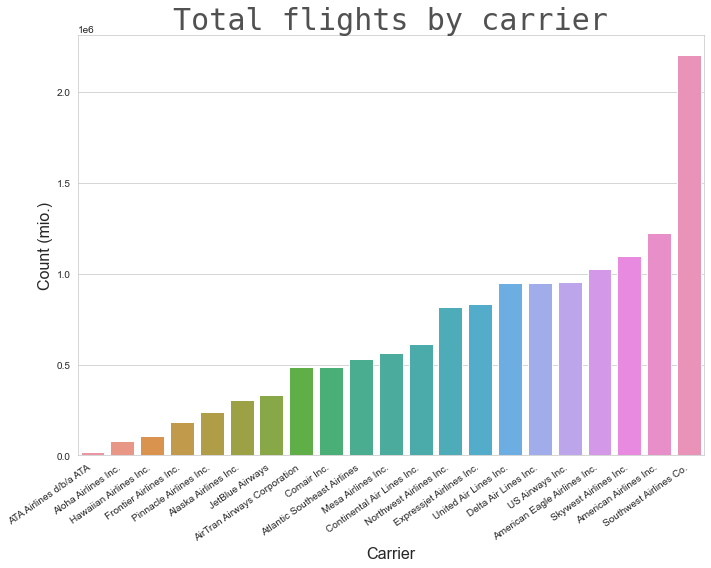

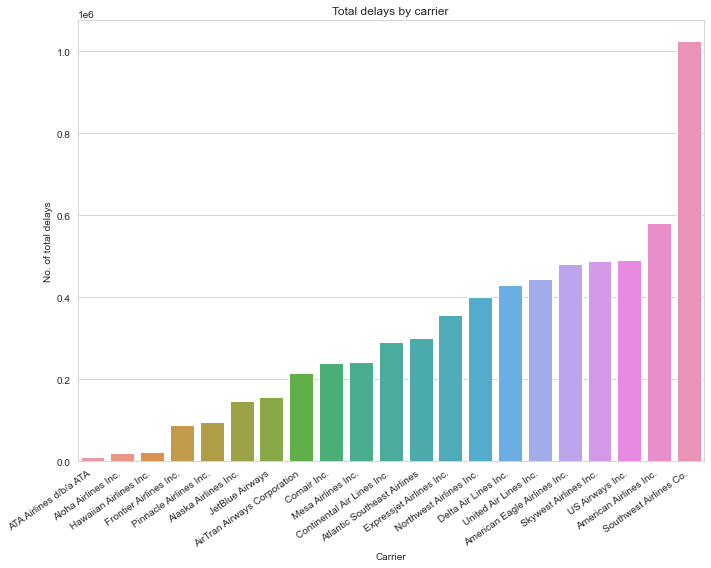

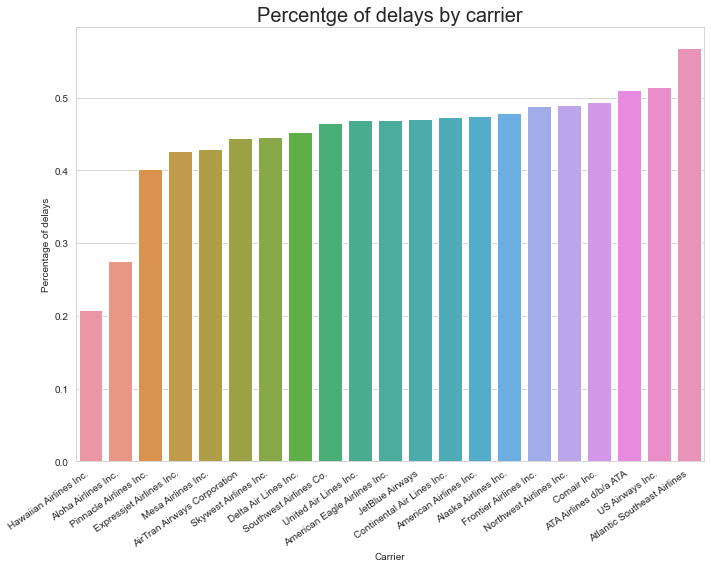

In [30]:
#multiple plots to gain better insight in delay by carrier.

#plot total flights by carrier (should show that Hawaiian has way less flights than big carriers)
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data= delay_merge.sort_values(by='fligts'),ax=ax, x=('Carrier'), y=('fligts'))
ax.set_title('Total flights by carrier',fontsize = 30, fontname="Monospace", alpha=.8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right") #rotate xlabel
ax.set_xlabel('Carrier',fontsize = 16)
ax.set_ylabel("Count (mio.)",fontsize = 16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig('EDA_plot4.png', bbox_inches='tight') #save img
plt.show() #plot

#plot total delays by carrier
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data= delay_merge.sort_values(by='total delays'),ax=ax, x=('Carrier'), y=('total delays'))
ax.set_title('Total delays by carrier')
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right") #rotate xlabel
ax.set_xlabel('Carrier')
ax.set_ylabel('No. of total delays')
plt.tight_layout() #tight layout
plt.show() #plot

#plot percentage delays by carrier
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data= delay_merge.sort_values(by='percentage'),ax=ax, x=('Carrier'), y=('percentage'))
ax.set_title('Percentge of delays by carrier', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right") #rotate xlabel
ax.set_xlabel('Carrier')
ax.set_ylabel('Percentage of delays')
plt.tight_layout() #tight layout
plt.show() #plot

#### The same could be done for airports, but given that there is many airports we select the 10 with most flights.

In [31]:
#merge df with airports, origin 
delay_by_airport = pd.merge(df, airports,  how='inner', left_on=['Origin'], right_on = ['iata'])
delay_by_airport #explore


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,Date,dep_hour_int,Date_bin,iata,airport,city,state,country,lat,long
0,2006,1,11,3,743.0,745,1024.0,1018,US,343,...,2006-01-11 07:43:00.740280,7,2006-01-11 07:00:00,ATL,William B Hartsfield-Atlanta Intl,Atlanta,GA,USA,33.640444,-84.426944
1,2006,1,11,3,1053.0,1053,1313.0,1318,US,613,...,2006-01-11 10:56:11.627880,10,2006-01-11 10:00:00,ATL,William B Hartsfield-Atlanta Intl,Atlanta,GA,USA,33.640444,-84.426944
2,2006,1,11,3,1915.0,1915,2110.0,2133,US,617,...,2006-01-11 19:53:21.773400,19,2006-01-11 19:00:00,ATL,William B Hartsfield-Atlanta Intl,Atlanta,GA,USA,33.640444,-84.426944
3,2006,1,12,4,1810.0,1820,1951.0,2003,US,1638,...,2006-01-12 18:47:55.827600,18,2006-01-12 18:00:00,ATL,William B Hartsfield-Atlanta Intl,Atlanta,GA,USA,33.640444,-84.426944
4,2006,1,12,4,1050.0,1020,1230.0,1203,US,1662,...,2006-01-12 10:54:19.458000,10,2006-01-12 10:00:00,ATL,William B Hartsfield-Atlanta Intl,Atlanta,GA,USA,33.640444,-84.426944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14007599,2007,11,29,4,1339.0,1315,1442.0,1445,9E,5970,...,2007-11-29 13:54:25.156440,13,2007-11-29 13:00:00,PIR,Pierre Regional,Pierre,SD,USA,44.382677,-100.285965
14007600,2007,12,7,5,1449.0,1315,1602.0,1445,9E,5970,...,2007-12-07 15:02:58.052040,14,2007-12-07 14:00:00,PIR,Pierre Regional,Pierre,SD,USA,44.382677,-100.285965
14007601,2007,12,3,1,1045.0,1000,1442.0,1400,9E,5998,...,2007-12-03 10:51:12.508200,10,2007-12-03 10:00:00,PIR,Pierre Regional,Pierre,SD,USA,44.382677,-100.285965
14007602,2007,4,26,4,646.0,655,748.0,740,9E,5703,...,2007-04-26 06:42:33.914160,6,2007-04-26 06:00:00,GLH,Mid Delta Regional,Greenville,MS,USA,33.482881,-90.985614


In [32]:
#create airport total flights df
delay_by_airport1 = delay_by_airport[['airport','iata']].groupby('airport').count()
delay_by_airport1.rename(columns={'iata': 'flights'}, inplace=True)
delay_by_airport1 = delay_by_airport1.sort_values(by=['flights'], ascending=False)
delay_by_airport1 = delay_by_airport1.reset_index(drop=False)

#carrier total delays df
delay_by_airport2=(delay_by_airport[delay_by_airport['delay']>0]['airport'].value_counts()) #delayed
delay_by_airport2=delay_by_airport2.to_frame(name=('total delays')) #to df
delay_by_airport2.index.name='airport' #set index name
delay_by_airport2=delay_by_airport2.reset_index(drop=False) #reset index

#merge to carrier delay df
delay_by_airport_merge = delay_by_airport1.merge(delay_by_airport2[['airport','total delays']],
                                  how='left',left_on='airport',right_on='airport')
delay_by_airport_merge['percentage']=(delay_by_airport_merge['total delays']/delay_by_airport_merge['flights']) #% delay column
delay_by_airport_merge = delay_by_airport_merge.head(10)
delay_by_airport_merge #explore new df

,airport,flights,total delays,percentage
0,William B Hartsfield-Atlanta Intl,791510,437413.0,0.552631
1,Chicago O'Hare International,705119,378087.0,0.536203
2,Dallas-Fort Worth International,571778,284884.0,0.498242
3,Los Angeles International,455728,211785.0,0.464718
4,Denver Intl,455553,228689.0,0.502003
5,Phoenix Sky Harbor International,413201,200347.0,0.484866
6,George Bush Intercontinental,411586,199255.0,0.484115
7,McCarran International,357418,183854.0,0.514395
8,Newark Intl,295697,155907.0,0.527253
9,Detroit Metropolitan-Wayne County,292748,161012.0,0.550002


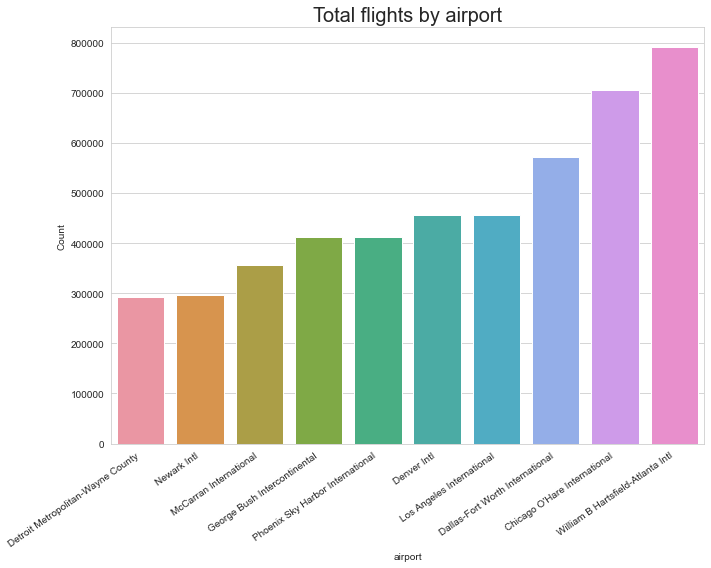

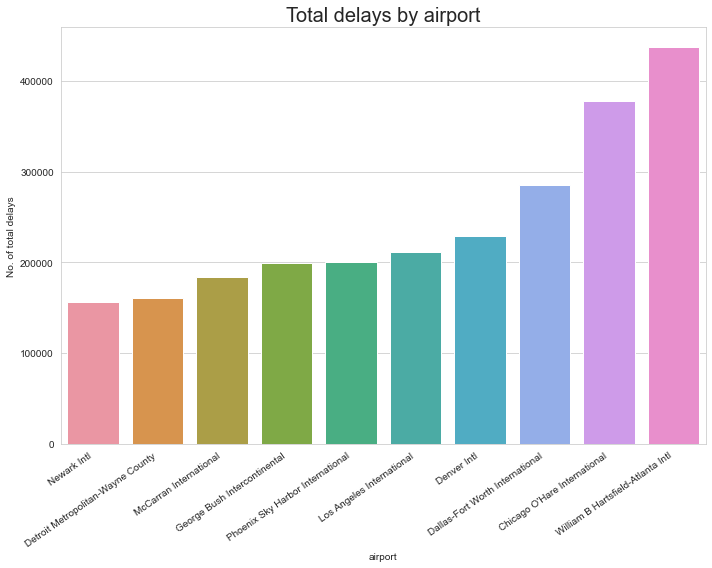

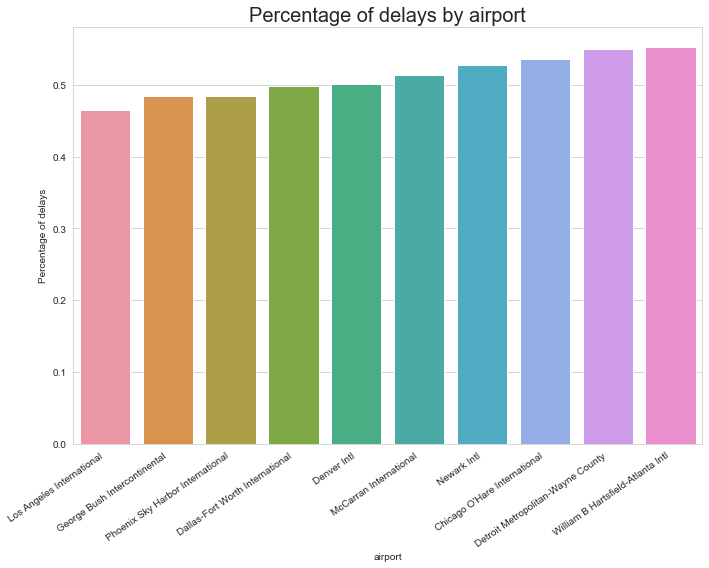

In [33]:
#multiple airport plots

#total flights 
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data= delay_by_airport_merge.sort_values(by='flights'),ax=ax, x=('airport'), y=('flights'))
ax.set_title('Total flights by airport', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right") #rotate xlabel
ax.set_xlabel('airport')
ax.set_ylabel("Count")
plt.tight_layout()
plt.show() #plot

#total delay
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data= delay_by_airport_merge.sort_values(by='total delays'),ax=ax, x=('airport'), y=('total delays'))
ax.set_title('Total delays by airport', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right") #rotate xlabel
ax.set_xlabel('airport')
ax.set_ylabel('No. of total delays')
plt.tight_layout() #tight layout
plt.show() #plot

#percentage of delays
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data= delay_by_airport_merge.sort_values(by='percentage'),ax=ax, x=('airport'), y=('percentage'))
ax.set_title('Percentage of delays by airport', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right") #rotate xlabel
ax.set_xlabel('airport')
ax.set_ylabel('Percentage of delays')
plt.tight_layout() #tight layout
plt.show() #plot

# 4. Questions

### Question 4.1.1
1. When is the best day of the week to fly to minimise delays?

In [34]:
#average delay in minutes by weekday (departure, arrival, and total delay)

#map days
df['DayOfWeek'] = df['DayOfWeek'].map({1:'Monday',2:'Tuesday',
                                       3:'Wednesday',4:'Thursday',5:'Friday',
                                       6:'Saturday',7:'Sunday'}).astype('str') #weekname column  
#create df with average values
day_mean=df[['DayOfWeek','DepDelay','ArrDelay']].groupby(['DayOfWeek']).mean() #mean delay by day
day_mean['Avg. delay']=(day_mean['DepDelay']+day_mean['ArrDelay'])/2 #avg. delay column
day_mean['Total avg. delay']=(day_mean['DepDelay']+day_mean['ArrDelay']) #tot. delay column
day_mean=day_mean.sort_values(by='Avg. delay',ascending=True) #arrange by avg. delay

#export table to img
day_mean = day_mean.reset_index(drop=False)
day_mean.rename(columns={'DayOfWeek': 'Day of Week', 'DepDelay': 
                         'Avg. Departure Delay','ArrDelay':
                         'Avg. Arrival Delay'}, inplace=True) #rename columns
day_mean_style = day_mean.style.background_gradient() #style table
dfi.export(day_mean_style,"Q1_1_table1.png") #export to png
day_mean_style #explore



,Day of Week,Avg. Departure Delay,Avg. Arrival Delay,Avg. delay,Total avg. delay
0,Saturday,8.609168,5.500266,7.054717,14.109433
1,Tuesday,8.517488,7.228652,7.873070,15.746140
2,Wednesday,9.756744,8.971638,9.364191,18.728382
3,Sunday,11.064771,9.235061,10.149916,20.299832
4,Monday,11.095161,9.691710,10.393436,20.786871
5,Thursday,12.304571,12.134668,12.219620,24.439239
6,Friday,13.300742,12.703370,13.002056,26.004112


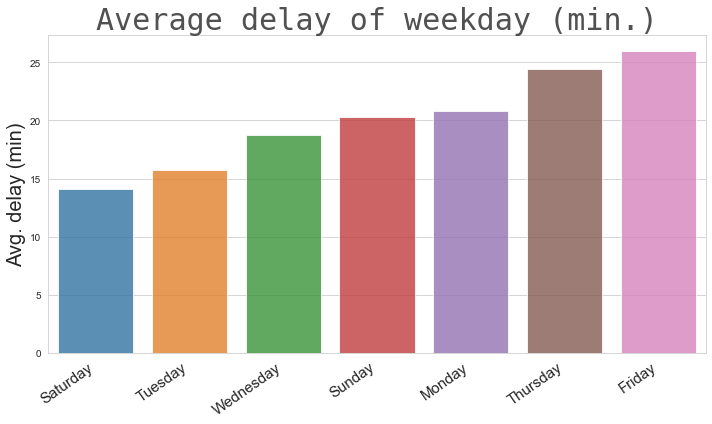

In [35]:
#plot bar chart mean delay delays total

#reset plot style for next to plots (to match color of bars)
sns.reset_orig()
sns.set_style("whitegrid")

f, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data = day_mean.sort_values(by='Total avg. delay'), 
            ax=ax, alpha=.8, x=('Day of Week'), y=('Total avg. delay'))

ax.set_title('Average delay of weekday (min.)', fontsize=30, fontname="Monospace", alpha=.8) #title
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right", fontsize = 15) #rotate xlabel
ax.set_ylabel('Avg. delay (min)', fontsize = 20)
ax.set_xlabel(xlabel=None) #remove obvioius xlabel
plt.tight_layout(rect=[0, 0, 1, 1]) #tight layout rect
plt.savefig('Q1_1_plot1.png', bbox_inches='tight') #save png
plt.show() #plot

In [36]:
#total flights/delays and percentage of delays by weekday (total delay)

#df with total no. of delay occrurences by weekday in percentage
day_total1=df[['DayOfWeek','delay']]
day_total1=df[['DayOfWeek','delay']].groupby(['DayOfWeek']).count() #group by day and count total per day.
day_total1['Flights(%)']=(day_total1['delay']/14007604)*100 #delay delays/ total flights in dataset
day_total1.rename(columns={'delay': 'Flights'}, inplace=True)

#total delays by weekday
day_total2 = df[['DayOfWeek','DepDelay','ArrDelay']]
day_total2 = (day_total2[(day_total2['DepDelay']>0) | (day_total2['ArrDelay']>0)])
day_total2.rename(columns={'DepDelay': 'Delays'}, inplace=True)
day_total2=day_total2.groupby(['DayOfWeek']).count()
day_total2.drop(['ArrDelay'], inplace=True, axis=1) #drop columns
day_total2

#merge on DayofWeek
day_total = pd.merge(day_total1, day_total2,  how='inner', left_on=['DayOfWeek'], 
                     right_on = ['DayOfWeek'])
day_total['Delays (%)'] = (day_total['Delays']/day_total['Flights']) #create delay in percentage column
day_total = day_total.sort_values(by='Delays (%)',ascending=True)#sort values

#prettify table
day_total = day_total.reset_index(drop=False)
day_total.rename(columns={'DayOfWeek': 'Day of Week'}, inplace=True)
day_total_style = day_total.style.background_gradient()
dfi.export(day_total_style,"Q1_1_table2.png")

day_total_style

,Day of Week,Flights,Flights(%),Delays,Delays (%)
0,Tuesday,2023777,14.447703,1047246,0.517471
1,Saturday,1767905,12.621038,918094,0.519312
2,Wednesday,2042684,14.582680,1104987,0.540949
3,Monday,2075083,14.813975,1164797,0.561325
4,Sunday,1972786,14.083679,1107784,0.561533
5,Thursday,2058307,14.694212,1206897,0.586354
6,Friday,2067062,14.756714,1255420,0.607345


In [37]:
my_palette = sns.color_palette("colorblind")


C:\Users\e2u\AppData\Local\Temp/ipykernel_28964/3591866742.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


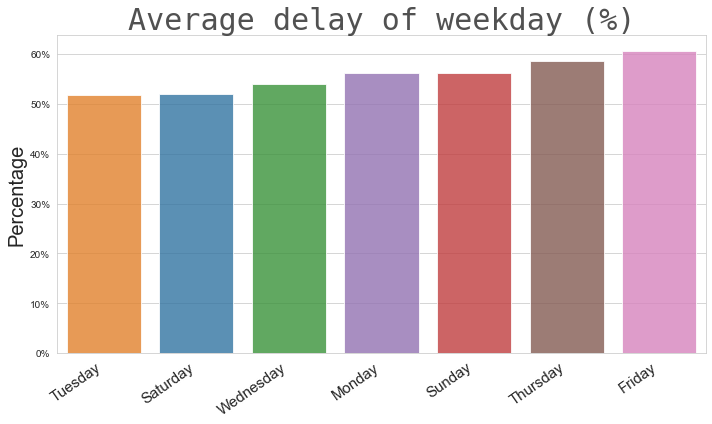

In [38]:
#plot bar chart mean delay delays total
f, ax = plt.subplots(figsize=(10, 6))

palette=['C1','C0','C2','C4','C3','C5','C6','c8'] #manually set day-color to match previous plot 

sns.barplot(data = day_total[['Day of Week','Delays (%)']],ax=ax,alpha=.8, palette=palette, 
            x=('Day of Week'), y=('Delays (%)'))

ax.set_title('Average delay of weekday (%)', fontsize=30, fontname="Monospace", alpha=.8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right", fontsize = 15) #rotate xlabel
ax.set_ylabel('Percentage', fontsize = 20)
ax.set_xlabel(xlabel=None) #remove obvioius xlabel
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 
plt.tight_layout(rect=[0, 0, 1, 1]) #tight layout
plt.savefig('Q1_1_plot2.png', bbox_inches='tight')
plt.show() #plot

In [39]:
#set plotting style for following plots in notebook
sns.reset_orig()
plt.style.use('seaborn-colorblind')
sns.set_style("whitegrid")

### Question 4.1.2
1. When is the best time of day to fly to minimise delays?

In [40]:
#check for missing outliers
print(df['ArrTime'].isna().sum())
print(df['ArrTime'].value_counts())

print(df['DepTime'].isna().sum())
df['DepTime'].value_counts()

0
1630.0    18702
1625.0    18463
1620.0    18455
1030.0    18315
1615.0    18188
          ...  
2621.0        1
2616.0        1
2748.0        1
2717.0        1
2650.0        1
Name: ArrTime, Length: 1635, dtype: int64
0


600.0     40088
700.0     40046
655.0     33360
630.0     28479
555.0     27682
          ...  
2507.0        1
2546.0        1
2533.0        1
2449.0        1
2557.0        1
Name: DepTime, Length: 1552, dtype: int64

In [41]:
#create bins with time of the day for ArrTime and DepTime
def condition1(i): 
    if i >= 0 and i <=600: return 'night'
    if i > 600 and i <=1200: return 'before noon'
    if i > 1200 and i <=1800: return 'afternoon'
    if i > 1800 and i <=2400: return 'evening'
    else: return 'other' #group invalid time entries (i.e 2600 in military time is not valid)

df['arr_time_bin']=df['ArrTime'].apply(condition1) #apply conditions to departure
df['dep_time_bin']=df['DepTime'].apply(condition1) #apply conditions to arrival

#choose related columns for df
time_day = df[['ArrTime','CRSArrTime','ArrDelay','DepTime','CRSDepTime',
               'DepDelay','delay','arr_time_bin', 'dep_time_bin']]
time_day =  time_day[(time_day['dep_time_bin'] != 'other') & 
                     (time_day['arr_time_bin'] != 'other')] #exclude 'none' = invalid time
time_day #explore

,ArrTime,CRSArrTime,ArrDelay,DepTime,CRSDepTime,DepDelay,delay,arr_time_bin,dep_time_bin
0,1024.0,1018,6.0,743.0,745,-2.0,4.0,before noon,before noon
1,1313.0,1318,-5.0,1053.0,1053,0.0,-5.0,afternoon,before noon
2,2110.0,2133,-23.0,1915.0,1915,0.0,-23.0,evening,evening
3,1925.0,1933,-8.0,1753.0,1755,-2.0,-10.0,evening,afternoon
4,1015.0,1015,0.0,824.0,832,-8.0,-8.0,before noon,before noon
...,...,...,...,...,...,...,...,...,...
14007599,844.0,825,19.0,634.0,630,4.0,23.0,before noon,before noon
14007600,1410.0,1420,-10.0,1300.0,1305,-5.0,-15.0,afternoon,afternoon
14007601,1115.0,1125,-10.0,955.0,1000,-5.0,-15.0,before noon,before noon
14007602,1623.0,1640,-17.0,1524.0,1526,-2.0,-19.0,afternoon,afternoon


In [42]:
#explore time bins for departure and arrival
print(time_day.arr_time_bin.value_counts())
print(time_day.dep_time_bin.value_counts())

afternoon      5222537
evening        4538810
before noon    3884116
night           358469
Name: arr_time_bin, dtype: int64
before noon    5363356
afternoon      5219518
evening        3072710
night           348348
Name: dep_time_bin, dtype: int64


In [43]:
#create time of day table for flights, delays, and delays %.

#total flights departure
time_day_dep=time_day[['dep_time_bin','delay']] #select columns
time_day_dep=time_day[['dep_time_bin','delay']].groupby(['dep_time_bin']).count() #group by day and count total per day.
time_day_dep = time_day_dep.reset_index(drop=False) #reset index
time_day_dep.rename(columns={'delay': 'Flights','dep_time_bin':'Time of day'}, inplace=True) #rename

#total flights arrival
time_day_arr=time_day[['arr_time_bin','delay']] #select columns
time_day_arr=time_day[['arr_time_bin','delay']].groupby(['arr_time_bin']).count() #group by day and count total per day.
time_day_arr = time_day_arr.reset_index(drop=False) #reset index
time_day_arr.rename(columns={'delay': 'Flights','arr_time_bin': 'Time of day'}, inplace=True)  #rename

#merge departure and arrival flights
time_day_tot_comb = pd.merge(time_day_dep, time_day_arr,  how='left', 
                             left_on=['Time of day'], right_on = ['Time of day'])
time_day_tot_comb['Flights'] = time_day_tot_comb['Flights_x']+time_day_tot_comb['Flights_y']
time_day_tot_comb = time_day_tot_comb[['Time of day','Flights']]

#create delay column for departure2
time_day_dep2 = time_day[['dep_time_bin','DepDelay']]
time_day_dep2 = (time_day_dep2[(time_day_dep2['DepDelay']>0)])
time_day_dep2 = time_day_dep2.groupby(['dep_time_bin']).count()
time_day_dep2 = time_day_dep2.reset_index(drop=False)
time_day_dep2.rename(columns={'DepDelay': 'Total dep. delay','dep_time_bin':
                              'Time of day'}, inplace=True)

#create delay column for arrival2
time_day_arr2 = time_day[['arr_time_bin','ArrDelay']]
time_day_arr2 = (time_day_arr2[(time_day_arr2['ArrDelay']>0)])
time_day_arr2 = time_day_arr2.groupby(['arr_time_bin']).count()
time_day_arr2 = time_day_arr2.reset_index(drop=False)
time_day_arr2.rename(columns={'ArrDelay': 'Total arr. delay','arr_time_bin':
                              'Time of day'}, inplace=True)


#merge departure and arrival delays
time_day_tot_comb2 = pd.merge(time_day_dep2, time_day_arr2,  how='left', 
                              left_on=['Time of day'], right_on = ['Time of day'])
time_day_tot_comb2['Delays'] = time_day_tot_comb2['Total dep. delay']+time_day_tot_comb2['Total arr. delay']

#merge all df's
time_day_df = pd.merge(time_day_tot_comb, time_day_tot_comb2,  how='left', 
                       left_on=['Time of day'], right_on = ['Time of day'])
time_day_df['Delayed (%)'] = (time_day_df['Delays']/time_day_df['Flights'])*100
time_day_df = time_day_df.sort_values(by='Delayed (%)',ascending=True)

time_day_df

,Time of day,Flights,Total dep. delay,Total arr. delay,Delays,Delayed (%)
1,before noon,9247472,1627109,1358423,2985532,32.284845
3,night,706817,58325,245173,303498,42.938696
0,afternoon,10442055,2426758,2386431,4813189,46.094270
2,evening,7611520,1719842,2528943,4248785,55.820454


In [44]:
#selct varibales and prettify table
time_day_df = time_day_df[['Time of day','Flights','Delays','Delayed (%)']]
time_day_df.rename(columns={'dep_time_bin': 'Time of Day'}, inplace=True)
time_day_df_style = time_day_df.style.background_gradient()
dfi.export(time_day_df_style,"Q1_2_table1.png") #to png
time_day_df_style

C:\Users\e2u\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Time of day,Flights,Delays,Delayed (%)
1,before noon,9247472,2985532,32.284845
3,night,706817,303498,42.938696
0,afternoon,10442055,4813189,46.094270
2,evening,7611520,4248785,55.820454


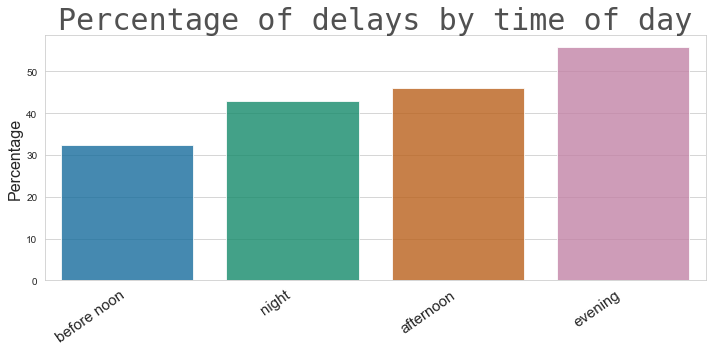

In [45]:
#plot bar chart total delay delays total for day
f, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data = time_day_df.sort_values(by='Delayed (%)'),ax=ax,alpha=.8, x=('Time of day'), y=('Delayed (%)'))
#labels
ax.set_title('Percentage of delays by time of day', fontsize=30, fontname="Monospace", alpha=.8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right", fontsize = 15) #rotate xlabel
ax.set_xlabel(xlabel=None) #remove obvioius xlabel
ax.set_ylabel('Percentage', fontsize = 16)
plt.tight_layout(rect=[0, 0, 1, 1]) #tight layout
plt.savefig('Q1_2_plot1.png', bbox_inches='tight')
plt.show() #plot

#### The lowest sum of the delays before noon (then delays at night must be longer). We can also calculate the mean delay by time of day

In [46]:
#mean of arrival delay
time_day_arr_mean = time_day[['ArrDelay','arr_time_bin']].groupby(['arr_time_bin']).mean().reset_index(drop=False)
time_day_arr_mean.rename(columns={'arr_time_bin': 'Time of day','ArrDelay':'Avg. Arrival Delay'}, inplace=True)

#mean of departure delay
time_day_dep_mean = time_day[['DepDelay','dep_time_bin']].groupby(['dep_time_bin']).mean().reset_index(drop=False)
time_day_dep_mean.rename(columns={'dep_time_bin': 'Time of day','DepDelay':'Avg. Departure Delay'}, inplace=True)

# merge and create total column
time_day_mean_comb = pd.merge(time_day_dep_mean, time_day_arr_mean,  how='left', left_on=['Time of day'], right_on = ['Time of day'])
time_day_mean_comb['Total avg. Delays'] = (time_day_mean_comb['Avg. Departure Delay'] + time_day_mean_comb['Avg. Arrival Delay'])
time_day_mean_comb=time_day_mean_comb.sort_values(by='Total avg. Delays',ascending=True)

#style table
time_day_mean_comb_style = time_day_mean_comb.style.background_gradient()
dfi.export(time_day_mean_comb_style,"Q1_2_table2.png")
time_day_mean_comb_style

,Time of day,Avg. Departure Delay,Avg. Arrival Delay,Total avg. Delays
1,before noon,3.224788,-0.028797,3.195991
0,afternoon,11.101738,6.702518,17.804255
2,evening,23.040655,17.104592,40.145247
3,night,10.594667,54.089681,64.684348


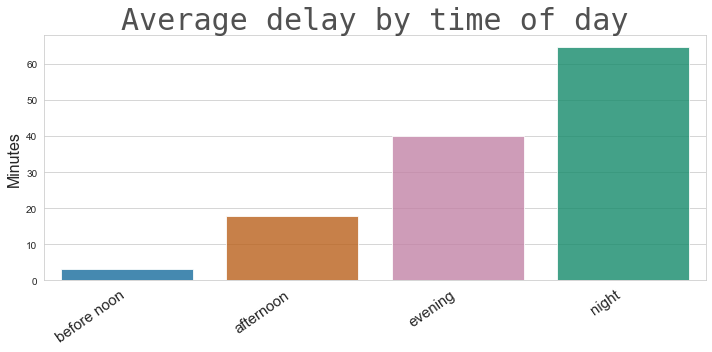

In [47]:
#plot bar chart total delay delays total for day
f, ax = plt.subplots(figsize=(10, 5))

palette=['C0','C2','C3','C1'] #set color to match days in previous plot

sns.barplot(data = time_day_mean_comb.sort_values(by='Total avg. Delays'),ax=ax,alpha=.8, x=('Time of day'), y=('Total avg. Delays'),palette=palette)

ax.set_title('Average delay by time of day', fontsize=30, fontname="Monospace", alpha=.8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right", fontsize = 15) #rotate xlabel
ax.set_xlabel(xlabel=None) #remove obvioius xlabel
ax.set_ylabel('Minutes', fontsize = 16)
plt.tight_layout(rect=[0, 0, 1, 1]) #tight layout
plt.savefig('Q1_2_plot2.png', bbox_inches='tight')
plt.show() #plot

The answer to the question depends on how you define the best way to minimise delays, if we are interested in the average or sum then it is best to travel before noon. If we only are interested in the total number of delay, we should travel at night (but if an delay occur - the probability for it to be longer than before noon is high)

We can conclude that it is best to travel before noon if we are risk-averse

### Question 4.1.3
1. When is the best time of year to fly to minimise delays?

In [48]:
#map months
df['Month'] = df['Month'].map({1:'January',2:'February',3:'March',4:'April',5:'May',
                               6:'June',7:'July',8:'August',9:'September',10:'October',
                               11:'November',12:'December'})
#df grouped by mean of month 
month_mean=df[['Month','DepDelay','ArrDelay']].groupby(['Month']).mean().reset_index(drop=False)
month_mean['Total Avg. Delay']=(month_mean['DepDelay']+month_mean['ArrDelay']) #mean of the delays
month_mean.rename(columns={'DepDelay': 'Departure delay','ArrDelay':'Arrival Delay'}, inplace=True)
month_mean = month_mean.sort_values(by='Total Avg. Delay',ascending=True)
month_mean_style = month_mean.style.background_gradient() #style
dfi.export(month_mean_style,"Q1_3_table1.png") #save to png
month_mean_style #explore

,Month,Departure delay,Arrival Delay,Total Avg. Delay
11,September,7.440537,6.080626,13.521163
9,November,8.179276,6.032137,14.211414
8,May,8.415244,6.971385,15.386629
4,January,9.168771,7.420203,16.588974
0,April,9.116255,7.474179,16.590434
10,October,9.261392,8.592198,17.853589
7,March,10.759757,9.006834,19.766591
3,February,11.553899,10.447546,22.001445
1,August,11.699477,10.638009,22.337486
5,July,13.720379,12.711885,26.432265


In [49]:
#total no. of delay occrurences by weekday in percentage
#month_total1=df[['Month','delay']]
month_total1=df[['Month','delay']].groupby(['Month']).count() #group by day and count total per day.
month_total1['Flights(%)']=(month_total1['delay']/14007604)*100 #delay delays/ total flights in dataset
month_total1.rename(columns={'delay': 'Flights'}, inplace=True)

#total delays by month
month_total2 = df[['Month','DepDelay','ArrDelay']]
month_total2 = (month_total2[(month_total2['DepDelay']>0) | (month_total2['ArrDelay']>0)])
month_total2.rename(columns={'DepDelay': 'Delays'}, inplace=True)
month_total2=month_total2.groupby(['Month']).count()
month_total2.drop(['ArrDelay'], inplace=True, axis=1) #drop columns

#merge on DayofWeek
month_total = pd.merge(month_total1, month_total2,  how='inner', left_on=['Month'], right_on = ['Month'])

#create delay in percentage column
month_total['Delayed (%)'] = month_total['Delays']/month_total['Flights']*100


#sort values
month_total = month_total.sort_values(by='Delayed (%)',ascending=True)

#export cell (dataframe_image library)
month_total = month_total.reset_index(drop=False)
month_total_style = month_total.style.background_gradient()
dfi.export(month_total_style,"Q1_3_table2.png")
month_total_style

,Month,Flights,Flights(%),Delays,Delayed (%)
0,September,1144554,8.170948,565474,49.405620
1,May,1194869,8.530145,623761,52.203296
2,November,1150995,8.216930,603368,52.421427
3,January,1152288,8.226161,608992,52.850676
4,April,1157432,8.262884,615026,53.137117
5,October,1197728,8.550556,658692,54.995124
6,March,1194570,8.528011,665851,55.739806
7,August,1232369,8.797857,701480,56.921263
8,February,1037214,7.404650,597747,57.630055
9,July,1217922,8.694720,729458,59.893655


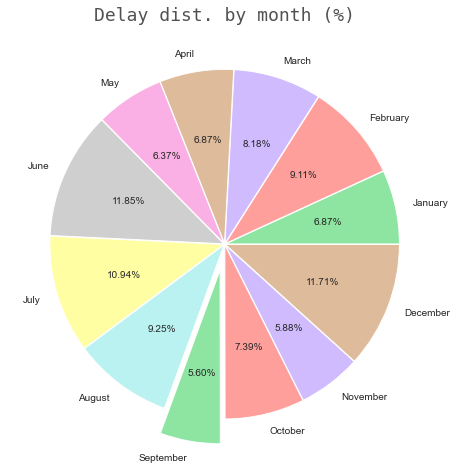

In [50]:
#piechart of average delay month

#data prep
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
               'August', 'September', 'October', 'November', 'December'] #list order
month_mean["Months"] = pd.Categorical(month_mean["Month"], categories=month_order) #map order
month_mean = month_mean.sort_values(by='Months') #sort

#pie chart
f, ax = plt.subplots(figsize=(10, 8))
explode = [0.005, 0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.15,0.005,0.005,0.005] #explode september
#create pie chart
plt.pie(month_mean['Total Avg. Delay'], labels= month_mean['Months'], colors = sns.color_palette('pastel')[2:13], 
        explode = explode, autopct='%.2f%%') #plot
plt.title('Delay dist. by month (%)', fontsize=18, fontname="Monospace", alpha=.8) #title
plt.savefig('Q1_3_plot1.png', bbox_inches='tight') #save to png
plt.show() #plot

The best month to travel avoid delay is in September. If the passenger has a biggertime window in mind, we can answer the question by seasons also:

In [51]:
season_total = month_total

#season total with function
def label1 (row):
   if row['Month'] == 'March' or row['Month'] == 'April' or row['Month'] == 'May':
      return 'Spring'
   if row['Month'] == 'June' or row['Month'] == 'July' or row['Month'] == 'August':
      return 'Summer'
   if row['Month'] == 'September' or row['Month'] == 'October' or row['Month'] == 'November':
      return 'Autumn'
   if row['Month'] == 'January' or row['Month'] == 'February' or row['Month'] == 'December':
      return 'Winter'
   return 'Other'
season_total['Month']=season_total.apply(lambda row: label1(row), axis=1)

#group and calculate season total df
season_total = season_total.groupby(['Month']).sum().reset_index(drop=False)
season_total['Delayed (%)'] = season_total['Delayed (%)']/3
season_total.rename(columns={'Month': 'Season'}, inplace=True)
season_total_style = season_total.style.background_gradient()
dfi.export(season_total_style,"Q1_3_table3.png")
season_total_style

,Season,Flights,Flights(%),Delays,Delayed (%)
0,Autumn,3493277,24.938433,1827534,52.274057
1,Spring,3546871,25.321040,1904638,53.693406
2,Summer,3623826,25.870420,2144262,59.199710
3,Winter,3343630,23.870107,1928791,57.681096


In [52]:
#same for mean:
season_mean = month_mean
def label2 (row):
   if row['Month'] == 'March' or row['Month'] == 'April' or row['Month'] == 'May':
      return 'Spring'
   if row['Month'] == 'June' or row['Month'] == 'July' or row['Month'] == 'August':
      return 'Summer'
   if row['Month'] == 'September' or row['Month'] == 'October' or row['Month'] == 'November':
      return 'Autumn'
   if row['Month'] == 'January' or row['Month'] == 'February' or row['Month'] == 'December':
      return 'Winter'
   return 'Other'
season_mean['Month']=season_mean.apply(lambda row: label2(row), axis=1)

#group and calculate season total df
season_mean = season_mean.groupby(['Month']).sum().reset_index(drop=False)
season_mean.rename(columns={'Month': 'Season','Departure delay':'Dep. delay (min)',
                            'Arrival Delay':'Arr. delay (min)'}, inplace=True)
season_mean_style = season_mean.style.background_gradient()
dfi.export(season_mean_style,"Q1_3_table4.png")
season_mean_style

,Season,Dep. delay (min),Arr. delay (min),Total Avg. Delay
0,Autumn,24.881204,20.704961,45.586166
1,Spring,28.291256,23.452398,51.743654
2,Summer,39.928955,37.462481,77.391436
3,Winter,35.341775,31.532482,66.874257


The month with fewest delay in average is September. As we might expect, the summer and christmas holidays has the most delays.


### Question 4.2

2. Do older planes suffer more delays?

In [53]:
#combine plane dataframe with planedata
df_airplanes= df.merge(airplanes[['tailnum','year']],how='left',left_on='TailNum',
                       right_on='tailnum') #join
df_airplanes=df_airplanes[df_airplanes['year'].isnull()==False] #exlude

#rename year from airplanes (to avoid confusion)
df_airplanes.rename(columns={'year': 'plane_year'}, inplace=True)
df_airplanes #explore 


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,Carrier,delay,dep_hour_standard,Date,dep_hour_int,Date_bin,arr_time_bin,dep_time_bin,tailnum,plane_year
0,2006,January,11,Wednesday,743.0,745,1024.0,1018,US,343,...,US Airways Inc.,4.0,7.716872,2006-01-11 07:43:00.740280000,7,2006-01-11 07:00:00,before noon,before noon,N657AW,1999
1,2006,January,11,Wednesday,1053.0,1053,1313.0,1318,US,613,...,US Airways Inc.,-5.0,10.936563,2006-01-11 10:56:11.627880000,10,2006-01-11 10:00:00,afternoon,before noon,N834AW,None
2,2006,January,11,Wednesday,1915.0,1915,2110.0,2133,US,617,...,US Airways Inc.,-23.0,19.889381,2006-01-11 19:53:21.773400000,19,2006-01-11 19:00:00,evening,evening,N605AW,1997
4,2006,January,11,Wednesday,824.0,832,1015.0,1015,US,765,...,US Airways Inc.,-8.0,8.558146,2006-01-11 08:33:29.327040000,8,2006-01-11 08:00:00,before noon,before noon,N309AW,1990
5,2006,January,11,Wednesday,627.0,630,834.0,832,US,295,...,US Airways Inc.,-1.0,6.512085,2006-01-11 06:30:43.504919999,6,2006-01-11 06:00:00,before noon,before noon,N733UW,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13766782,2007,January,13,Saturday,1756.0,1800,1833.0,1837,AQ,225,...,Aloha Airlines Inc.,-8.0,18.237992,2007-01-13 18:14:16.769760000,17,2007-01-13 17:00:00,evening,afternoon,N823AL,1985
13766783,2007,June,7,Thursday,700.0,705,731.0,739,AQ,245,...,Aloha Airlines Inc.,-13.0,7.270270,2007-06-07 07:16:12.972000000,7,2007-06-07 07:00:00,before noon,before noon,N836AL,1985
13766784,2007,November,6,Tuesday,1247.0,1255,1957.0,1956,AQ,468,...,Aloha Airlines Inc.,-7.0,12.951467,2007-11-06 12:57:05.280120000,12,2007-11-06 12:00:00,evening,afternoon,N748AL,1999
13766785,2007,October,10,Wednesday,1035.0,1030,1253.0,1253,AQ,473,...,Aloha Airlines Inc.,5.0,10.749614,2007-10-10 10:44:58.608600000,10,2007-10-10 10:00:00,afternoon,before noon,N748AL,1999


In [54]:
df_airplanes.isna().sum()

Year                        0
Month                       0
DayofMonth                  0
DayOfWeek                   0
DepTime                     0
CRSDepTime                  0
ArrTime                     0
CRSArrTime                  0
UniqueCarrier               0
FlightNum                   0
TailNum                     0
ActualElapsedTime           0
CRSElapsedTime              0
AirTime                     0
ArrDelay                    0
DepDelay                    0
Origin                      0
Dest                        0
Distance                    0
TaxiIn                      0
TaxiOut                     0
Cancelled                   0
CancellationCode     11687529
Diverted                    0
CarrierDelay                0
WeatherDelay                0
NASDelay                    0
SecurityDelay               0
LateAircraftDelay           0
Code                        0
Carrier                     0
delay                       0
dep_hour_standard           0
Date      

In [55]:
#NA's in plane_year is zero, but a closer look reveals the some values = None(a missing value)
df_airplanes.value_counts('plane_year').head(15)

plane_year
2001    1082717
2002     871978
2000     855726
2003     826010
1999     822589
2004     719876
1998     663853
2005     581238
1996     379217
1988     378882
1991     361447
1997     350159
None     344234
1992     332213
1990     332049
dtype: int64

In [56]:
#exclude the 'None' values
df_airplanes = df_airplanes[df_airplanes.plane_year != 'None']
df_airplanes.value_counts('plane_year').head(15) #verify

plane_year
2001    1082717
2002     871978
2000     855726
2003     826010
1999     822589
2004     719876
1998     663853
2005     581238
1996     379217
1988     378882
1991     361447
1997     350159
1992     332213
1990     332049
1987     327598
dtype: int64

In [57]:
df_airplanes['plane_year'].dtype #check dtype

dtype('O')

In [58]:
df_airplanes['plane_year'] = df_airplanes['plane_year'].astype(int) #change to integer
df_airplanes['plane_year'].dtype #verify

C:\Users\e2u\AppData\Local\Temp/ipykernel_28964/4044500668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_airplanes['plane_year'] = df_airplanes['plane_year'].astype(int) #change to integer


dtype('int32')

Now that the data is ready, we can continue:

First we have to define what an old plane is: Assuming an plane manifactured over 20 years ago is consired an old plane
+ reference: (https://www.paramountbusinessjets.com/faq/age-of-aircraft-safety-factor.html)

<code>&nbsp</code>

The lates data collected is from 2007, so we an old plane would be manufactured before year 1987

In [59]:
#categorise the planes either as old or new by manifacturing year
bins = [1920,1987,2022]
labels=['old','new']
df_airplanes['plane_condition'] = pd.cut(df_airplanes['plane_year'], bins=bins, labels=labels)

#create a delayed boolean column 
df_airplanes['Delayed_bool'] = (df_airplanes['DepDelay']>0) | (df_airplanes['ArrDelay']>0)
df_airplanes['Delayed_bool'] = df_airplanes['Delayed_bool']*1

df_airplanes_bin=df_airplanes[['plane_condition','plane_year','delay','Delayed_bool', 'ArrDelay','DepDelay']]
df_airplanes_bin

C:\Users\e2u\AppData\Local\Temp/ipykernel_28964/4092204926.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_airplanes['plane_condition'] = pd.cut(df_airplanes['plane_year'], bins=bins, labels=labels)
C:\Users\e2u\AppData\Local\Temp/ipykernel_28964/4092204926.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_airplanes['Delayed_bool'] = (df_airplanes['DepDelay']>0) | (df_airplanes['ArrDelay']>0)
C:\Users\e2u\AppData\Local\Temp/ipykernel_28964/4092204926.py:8: SettingWithCopyWarning: 
A value is try

,plane_condition,plane_year,delay,Delayed_bool,ArrDelay,DepDelay
0,new,1999,4.0,1,6.0,-2.0
2,new,1997,-23.0,0,-23.0,0.0
4,new,1990,-8.0,0,0.0,-8.0
5,new,2000,-1.0,1,2.0,-3.0
7,new,1989,4.0,1,7.0,-3.0
...,...,...,...,...,...,...
13766782,old,1985,-8.0,0,-4.0,-4.0
13766783,old,1985,-13.0,0,-8.0,-5.0
13766784,new,1999,-7.0,1,1.0,-8.0
13766785,new,1999,5.0,1,0.0,5.0


In [60]:
df_airplanes_bin.isna().sum()

plane_condition    10200
plane_year             0
delay                  0
Delayed_bool           0
ArrDelay               0
DepDelay               0
dtype: int64

In [61]:
#the new NA's is must be occuring due to the year bins, let's adress these:

#check for outlier values
print(df_airplanes_bin['plane_year'].min())
print(df_airplanes_bin['plane_year'].max())

0
2007


In [62]:
#0 is definetely not a correct value for manufacturing year, lets drop theese.

df_airplanes_bin = df_airplanes_bin[df_airplanes_bin['plane_year'] > 1900] #exclude 0
print(df_airplanes_bin['plane_year'].min())
print(df_airplanes_bin['plane_year'].max())

1956
2007


In [63]:
#Year 1956 seems more likely to be the manifacturing year of the oldest plane.
#NA's in df_airplanes should now be zero.
df_airplanes_bin.isna().sum()

plane_condition    0
plane_year         0
delay              0
Delayed_bool       0
ArrDelay           0
DepDelay           0
dtype: int64

In [64]:
#Total no. of old and new planes
df_airplanes_bin.plane_condition.value_counts()


new    10100202
old     1232894
Name: plane_condition, dtype: int64

In [65]:
#total no. of delay occrurences by weekday in percentage
df_airplanes_bin1=df_airplanes_bin[['plane_condition','delay']].groupby(['plane_condition']).count() #group by day and count total per day.
df_airplanes_bin1['Flights(%)']=(df_airplanes_bin1['delay']/(10100221+1232687) )*100 #divide with total flights by old and new planes
df_airplanes_bin1.rename(columns={'delay': 'Flights'}, inplace=True)
df_airplanes_bin1

#total delays by weekday
df_airplanes_bin2 = df_airplanes_bin[['plane_condition','Delayed_bool']].groupby(['plane_condition']).sum()
df_airplanes_bin2.rename(columns={'Delayed_bool': 'Delays'}, inplace=True)

df_airplanes_tab = pd.merge(df_airplanes_bin1, df_airplanes_bin2,  how='inner', left_on=['plane_condition'], right_on = ['plane_condition'])

#create delay in percentage column
df_airplanes_tab['Delayed (%)'] = df_airplanes_tab['Delays']/df_airplanes_tab['Flights']*100

#sort values
df_airplanes_tab = df_airplanes_tab.sort_values(by='Delayed (%)',ascending=True)

#export cell (dataframe_image library)
df_airplanes_tab = df_airplanes_tab.reset_index(drop=False)
df_airplanes_tab.rename(columns={'plane_condition': 'Plane Condition'}, inplace=True)
df_airplanes_tab_style = df_airplanes_tab.style.background_gradient()
dfi.export(df_airplanes_tab_style,"Q2_table1.png")
df_airplanes_tab_style

,Plane Condition,Flights,Flights(%),Delays,Delayed (%)
0,new,10100202,89.122774,5646938,55.909159
1,old,1232894,10.878885,714373,57.942775


In [66]:
#airplane mean by manu. year
df_airplanes_mean=df_airplanes_bin[['plane_condition',
                                    'DepDelay','ArrDelay','delay']].groupby(['plane_condition']).mean().reset_index(drop=False) #group
df_airplanes_mean.rename(columns={'delay': 
                                  'Total avg. delay','ArrDelay':'Avg. Arrival Delay',
                                  'DepDelay':'Avg. Departure Delay','plane_condition': 'Plane Condition'}, inplace=True) #rename
df_airplanes_mean = df_airplanes_mean.sort_values(by='Total avg. delay',ascending=True) #sort
df_airplanes_mean_style = df_airplanes_mean.style.background_gradient()
dfi.export(df_airplanes_mean_style,"Q2_table2.png")
df_airplanes_mean_style

,Plane Condition,Avg. Departure Delay,Avg. Arrival Delay,Total avg. delay
1,new,10.792953,9.655673,20.448626
0,old,10.501595,10.139588,20.641182


In [67]:
#merge the tables

df_airplanes_comb = pd.merge(df_airplanes_tab,df_airplanes_mean,  how='inner', left_on=['Plane Condition'], right_on = ['Plane Condition'])

df_airplanes_comb_style = df_airplanes_comb.style.background_gradient() #style
dfi.export(df_airplanes_comb_style,"Q2_table3.png") #export to png
df_airplanes_comb_style #explore

,Plane Condition,Flights,Flights(%),Delays,Delayed (%),Avg. Departure Delay,Avg. Arrival Delay,Total avg. delay
0,new,10100202,89.122774,5646938,55.909159,10.792953,9.655673,20.448626
1,old,1232894,10.878885,714373,57.942775,10.501595,10.139588,20.641182


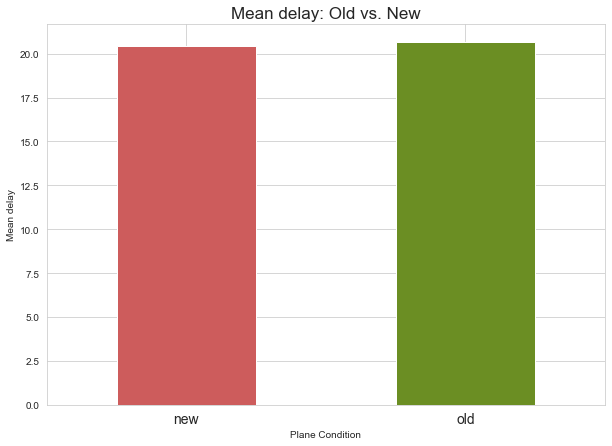

In [68]:
#plot mean delay

df_airplanes_mean = df_airplanes_mean.reset_index(drop=False)

#plot barchart
f, ax = plt.subplots(figsize=(10, 7))

df_airplanes_mean.plot(kind = 'bar',ax=ax, x='Plane Condition',y='Total avg. delay', color=['indianred', 'olivedrab'],legend=None)

#set labels
ax.set_title("Mean delay: Old vs. New", fontsize=17) #title
plt.ylabel("Mean delay") #ylabel
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center",fontsize=14 ) #rotate xlabel
#plt.tight_layout() #tight layout
plt.show() #plot

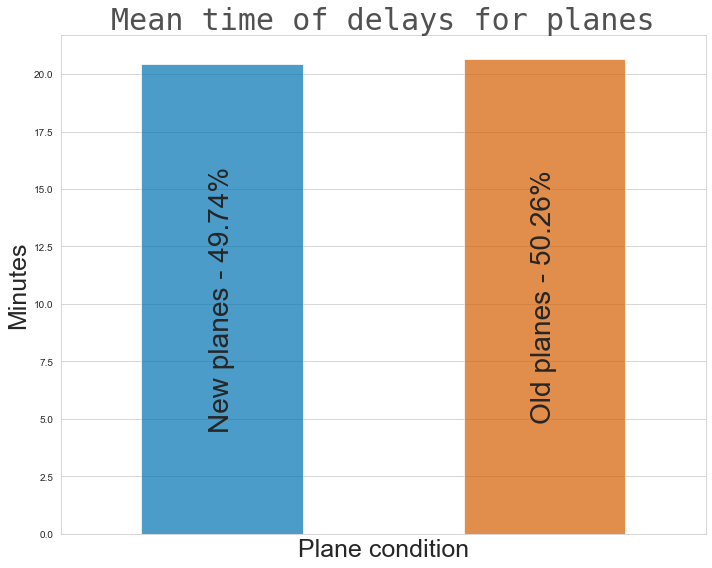

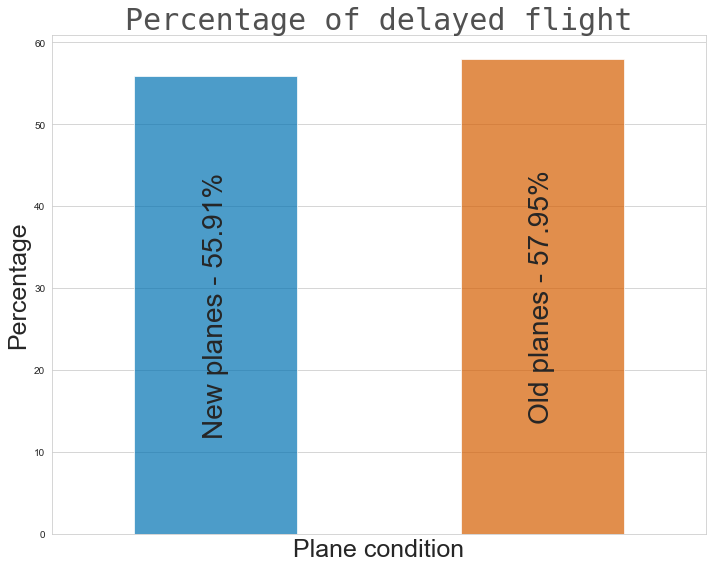

In [69]:
#plot data prep
condition_data=[20.436394,20.647952] 
condition_dec = pd.Series(index = ["New planes", "Old planes"], data=condition_data) #create series
percentage = condition_dec.div(condition_dec.sum()).mul(100).round(2) #calc. the percentage and round 2 dec



#barplot 
ax = condition_dec.plot(kind="bar", alpha=0.7, figsize=(10, 8), color=palette)
#set labels inside the bars
labels = [f'{condition_dec} - {percentage[condition_dec]}%' for condition_dec in condition_dec.index]
for label, a in zip(labels, ax.patches):
    left, bottom, width, height = a.get_bbox().bounds
    ax.annotate(label, xy=(left+width/2, bottom+height/2), ha='center', va='center', rotation=90, fontsize=28)
#labels
plt.ylabel("Minutes", fontsize=25) #ylabel
plt.xlabel("Plane condition", fontsize=25) #xlabel
plt.title("Mean time of delays for planes", fontsize=30, fontname="Monospace", alpha=.8) #title
plt.xticks([]) #empty xticks
plt.tight_layout(rect=[0, 0, 1, 1]) #tight layout (rectangular)
plt.savefig('Q2_plot1.png', bbox_inches='tight') #save img
plt.show()

#same for total delays by plane:
#data prep
condition_data2=[55.906308,57.950508] 
condition_dec2 = pd.Series(index = ["New planes - 55.91", "Old planes - 57.95"], data=condition_data2) #create series

#barplot 
ax = condition_dec2.plot(kind="bar", alpha=0.7, figsize=(10, 8), color=palette)
#set labels inside the bars
labels = [f'{condition_dec2}%' for condition_dec2 in condition_dec2.index]
for label, a in zip(labels, ax.patches):
    left, bottom, width, height = a.get_bbox().bounds
    ax.annotate(label, xy=(left+width/2, bottom+height/2), ha='center', va='center', rotation=90, fontsize=28)
#labels
plt.ylabel("Percentage", fontsize=25) #ylabel
plt.xlabel("Plane condition", fontsize=25) #xlabel
plt.title("Percentage of delayed flight", fontsize=30, fontname="Monospace", alpha=.8) #title
plt.xticks([]) #empty xticks
plt.tight_layout(rect=[0, 0, 1, 1]) #tight layout (rectangular)
plt.savefig('Q2_plot2.png', bbox_inches='tight') #save img
plt.show()

Old planes do not suffer signficantly more average delay (in minutes) than new planes. But older planes do have approx. 2% higher percentage of flights that are delayed. I don't think the 2% is enough to conclude they suffer more delays. To conclude old planes are on level with absolute certainty, we can use a chi squared test to decice if a relationship exists between the variables plane_year and delayed.

In [70]:
#chi-squared test

#create a contingency table
airplane_contingency  = pd.crosstab(df_airplanes['plane_condition'],
                            df_airplanes['Delayed_bool'],
                           margins=True, margins_name="Total") #margins=true adds total column
airplane_contingency #explore table

#calculate relation
chi2, p, expected,dof  = chi2_contingency(airplane_contingency)
print("H0: Old planes does not suffer more delay VS. H1:Old planes suffer more delay ")
print(f"P Value:            {p:.4f}")
if p >=0.05:
  print("We reject the null hypotheses at a 5% significance level") #% significance level
else:
  print("We FAIL reject the null hypotheses at a 5% significance level")

#we also test at a 10% significance level due to the close mean values
if p >=0.10:
  print("We reject the null hypotheses at a 10% significance level") #10% significance level
else:
  print("We also FAIL reject the null hypotheses at a 10% significance level")

H0: Old planes does not suffer more delay VS. H1:Old planes suffer more delay 
P Value:            0.0000
We FAIL reject the null hypotheses at a 5% significance level
We also FAIL reject the null hypotheses at a 10% significance level


As expected, we reject the null hypothesis, hence there is evidence suggesting that older planes do not suffer more delays. The test result is highly significant.


Maybe our threshold definition introduce some level of bias, let's try changing the bins to 30 years in bins of 10.


In [71]:
#categorise the planes either as old or new by manifacturing year
bins = [0,1987,1997,2022]
labels=['1956-1987(old)','1987-1997(mid)','1997-2007(new)']
df_airplanes['plane_condition2'] = pd.cut(df_airplanes['plane_year'], bins=bins, labels=labels)
df_airplanes_bin2=df_airplanes[['plane_condition2','plane_year','delay','Delayed_bool', 
                                'ArrDelay','DepDelay']]

#group by condition and mean
df_airplanes_mean2=df_airplanes_bin2[['plane_condition2',
                                      'DepDelay','ArrDelay',
                                      'delay']].groupby(['plane_condition2']).mean().reset_index(drop=False)
df_airplanes_mean2.rename(columns={'plane_condition2':
                                   'Plane Condition','delay': 'Total avg. delay','ArrDelay':
                                   'Avg. Arrival Delay','DepDelay':
                                   'Avg. Departure Delay'}, inplace=True)
df_airplanes_mean2 = df_airplanes_mean2.sort_values(by='Total avg. delay',ascending=True)
df_airplanes_mean2_style = df_airplanes_mean2.style.background_gradient() #style
dfi.export(df_airplanes_mean2_style,"Q2_table4.png") #export to png
df_airplanes_mean2_style #explore

C:\Users\e2u\AppData\Local\Temp/ipykernel_28964/849879242.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_airplanes['plane_condition2'] = pd.cut(df_airplanes['plane_year'], bins=bins, labels=labels)


,Plane Condition,Avg. Departure Delay,Avg. Arrival Delay,Total avg. delay
2,1997-2007(new),10.664847,9.476803,20.141650
0,1956-1987(old),10.501595,10.139588,20.641182
1,1987-1997(mid),11.059478,10.027815,21.087293


In [72]:
#total no. of delay occrurences by weekday in percentage
df_airplanes_bin2_1=df_airplanes_bin2[['plane_condition2','delay']].groupby(['plane_condition2']).count() #group by day and count total per day.
df_airplanes_bin2_1.rename(columns={'delay': 'Flights'}, inplace=True)
df_airplanes_bin2_1['Flights(%)']=(df_airplanes_bin2_1['Flights']/11332781 )*100 #divide with total flights by old and new planes


#total delays by weekday
df_airplanes_bin2_2 = df_airplanes_bin2[['plane_condition2','Delayed_bool']].groupby(['plane_condition2']).sum()
df_airplanes_bin2_2.rename(columns={'Delayed_bool': 'Delays'}, inplace=True)

#merge on plane condition
df_airplanes_bin2_tab = pd.merge(df_airplanes_bin2_1, df_airplanes_bin2_2,  how='inner', left_on=['plane_condition2'], right_on = ['plane_condition2'])

#create delay in percentage column
df_airplanes_bin2_tab['Delayed (%)'] = df_airplanes_bin2_tab['Delays']/df_airplanes_bin2_tab['Flights']*100

#create delay in percentage column
df_airplanes_bin2_tab['Delayed (%)'] = df_airplanes_bin2_tab['Delays']/df_airplanes_bin2_tab['Flights']*100
df_airplanes_bin2_tab=df_airplanes_bin2_tab.reset_index(drop=False)
df_airplanes_bin2_tab.rename(columns={'plane_condition2': 'Plane Condition'}, inplace=True)


df_airplanes_bin_comb = pd.merge(df_airplanes_bin2_tab,df_airplanes_mean2,  how='inner', left_on=['Plane Condition'], right_on = ['Plane Condition'])

df_airplanes_bin_comb_style = df_airplanes_bin_comb.style.background_gradient() #style
dfi.export(df_airplanes_bin_comb_style,"Q2_table5.png") #export to png
df_airplanes_bin_comb_style #explore

,Plane Condition,Flights,Flights(%),Delays,Delayed (%),Avg. Departure Delay,Avg. Arrival Delay,Total avg. delay
0,1956-1987(old),1232894,10.879007,714373,57.942775,10.501595,10.139588,20.641182
1,1987-1997(mid),3278748,28.931539,1871475,57.078952,11.059478,10.027815,21.087293
2,1997-2007(new),6821454,60.192233,3775463,55.346895,10.664847,9.476803,20.141650


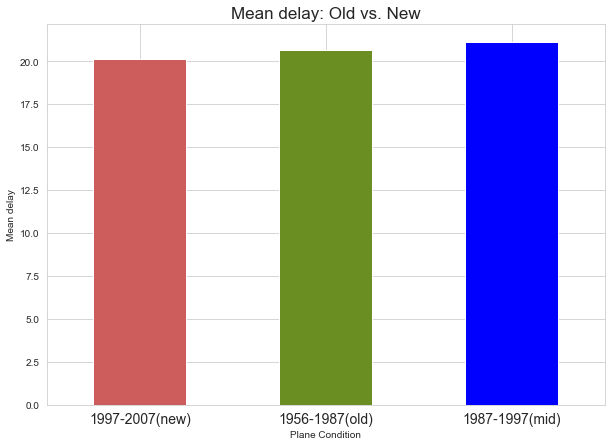

In [73]:
df_airplanes_mean2 = df_airplanes_mean2.reset_index(drop=False)

#plot barchart
f, ax = plt.subplots(figsize=(10, 7))

df_airplanes_mean2.plot(kind = 'bar',ax=ax, x='Plane Condition',y='Total avg. delay',color=['indianred', 'olivedrab', 'blue'],legend=None)

#set labels
ax.set_title("Mean delay: Old vs. New", fontsize=17) #title
plt.ylabel("Mean delay") #ylabel
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center",fontsize=14 ) #rotate xlabel
#plt.tight_layout() #tight layout
plt.show() #plot

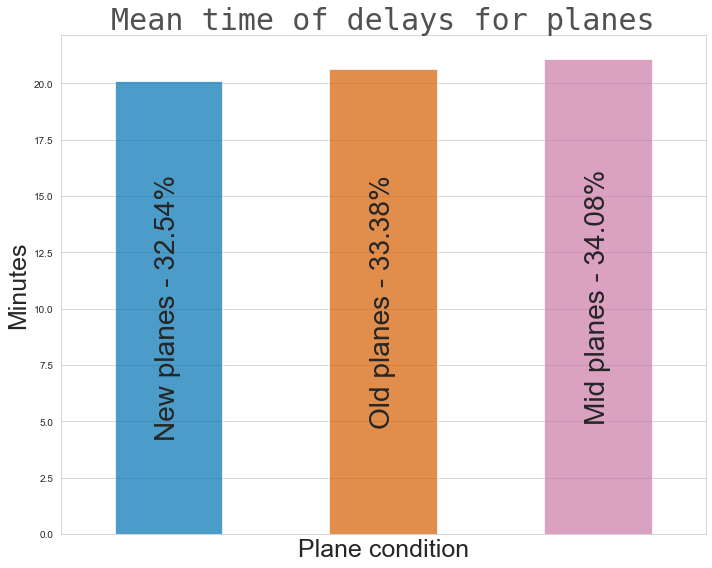

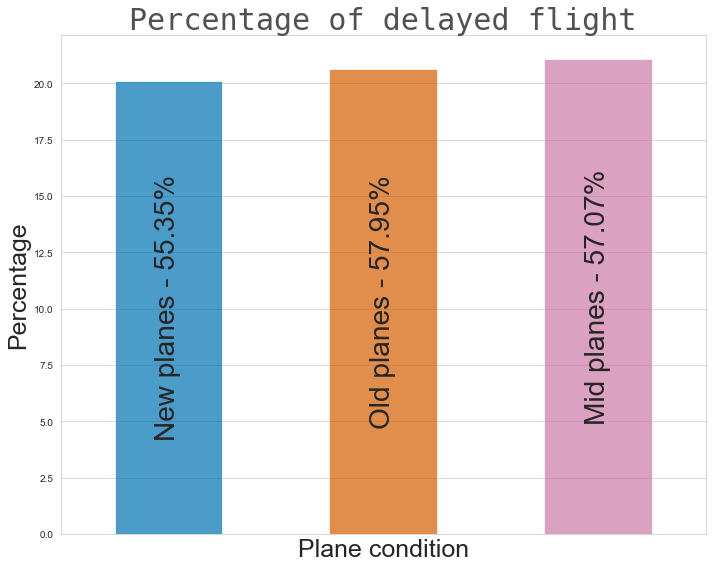

In [74]:
#prettify the plot for report
condition_data3=[20.127357,20.647952,21.079243] 
condition_dec3 = pd.Series(index = ["New planes", "Old planes",'Mid planes'], data=condition_data3) #create series
percentage3 = condition_dec3.div(condition_dec3.sum()).mul(100).round(2) #calc. the percentage and round 2 dec

#barplot 
ax = condition_dec3.plot(kind="bar", alpha=0.7, figsize=(10, 8), color=palette)
#set labels inside the bars
labels = [f'{condition_dec3} - {percentage3[condition_dec3]}%' for condition_dec3 in condition_dec3.index]
for label, a in zip(labels, ax.patches):
    left, bottom, width, height = a.get_bbox().bounds
    ax.annotate(label, xy=(left+width/2, bottom+height/2), ha='center', va='center', rotation=90, fontsize=28)
#labels
plt.ylabel("Minutes", fontsize=25) #ylabel
plt.xlabel("Plane condition", fontsize=25) #xlabel
plt.title("Mean time of delays for planes", fontsize=30, fontname="Monospace", alpha=.8) #title
plt.xticks([]) #empty xticks
plt.tight_layout(rect=[0, 0, 1, 1]) #tight layout (rectangular)
plt.savefig('Q2_plot3.png', bbox_inches='tight') #save img
plt.show()


#prettify the plot for report
condition_data4=[55.35,57.95,57.07] 
condition_dec4 = pd.Series(index = ["New planes - 55.35", "Old planes - 57.95",'Mid planes - 57.07'], data=condition_data3) #create series

#barplot 
ax = condition_dec3.plot(kind="bar", alpha=0.7, figsize=(10, 8), color=palette)
#set labels inside the bars
labels = [f'{condition_dec4}%' for condition_dec4 in condition_dec4.index]
for label, a in zip(labels, ax.patches):
    left, bottom, width, height = a.get_bbox().bounds
    ax.annotate(label, xy=(left+width/2, bottom+height/2), ha='center', va='center', rotation=90, fontsize=28)
#labels
plt.ylabel("Percentage", fontsize=25) #ylabel
plt.xlabel("Plane condition", fontsize=25) #xlabel
plt.title("Percentage of delayed flight", fontsize=30, fontname="Monospace", alpha=.8) #title
plt.xticks([]) #empty xticks
plt.tight_layout(rect=[0, 0, 1, 1]) #tight layout (rectangular)
plt.savefig('Q2_plot4.png', bbox_inches='tight') #save img
plt.show()

Changing the bins gives a better insight in the life of a plane. When a plane above 10 years the delays increase a little, but decreases again when the plane is +20 year. The mean delay time is still pretty close though.


### Question 4.3

3. How does the number of people flying between different locations change over time?

In [75]:
#load data for a ten year period, same encoding used for all.
df_97 = pd.read_csv("1997.csv", usecols = ["Origin", "Dest", "Year"], encoding='latin-1')
df_98 = pd.read_csv("1998.csv", usecols = ["Origin", "Dest", "Year"], encoding='latin-1')
df_99 = pd.read_csv("1999.csv", usecols = ["Origin", "Dest", "Year"], encoding='latin-1')
df_00 = pd.read_csv("2000.csv", usecols = ["Origin", "Dest", "Year"], encoding='latin-1')
df_01 = pd.read_csv("2001.csv", usecols = ["Origin", "Dest", "Year"], encoding='latin-1')
df_02 = pd.read_csv("2002.csv", usecols = ["Origin", "Dest", "Year"], encoding='latin-1')
df_03 = pd.read_csv("2003.csv", usecols = ["Origin", "Dest", "Year"], encoding='latin-1')
df_04 = pd.read_csv("2004.csv", usecols = ["Origin", "Dest", "Year"], encoding='latin-1')
df_05 = pd.read_csv("2005.csv", usecols = ["Origin", "Dest", "Year"], encoding='latin-1')
df_06 = pd.read_csv("2006.csv", usecols = ["Origin", "Dest", "Year"], encoding='latin-1') 
df_07 = pd.read_csv("2007.csv", usecols = ["Origin", "Dest", "Year"], encoding='latin-1')  


In [76]:
#group data and rename the year column to avoid confusion
df_97 = df_97.groupby(['Origin','Dest']).count().sort_values(by=['Year'], ascending=False)
df_97.rename(columns={'Year': '1997'}, inplace=True) #year 1997
df_98 = df_98.groupby(['Origin','Dest']).count().sort_values(by=['Year'], ascending=False)
df_98.rename(columns={'Year': '1998'}, inplace=True)#year 1998
df_99 = df_99.groupby(['Origin','Dest']).count().sort_values(by=['Year'], ascending=False)
df_99.rename(columns={'Year': '1999'}, inplace=True)#year 1999
df_00 = df_00.groupby(['Origin','Dest']).count().sort_values(by=['Year'], ascending=False)
df_00.rename(columns={'Year': '2000'}, inplace=True)#year 2000
df_01 = df_01.groupby(['Origin','Dest']).count().sort_values(by=['Year'], ascending=False)
df_01.rename(columns={'Year': '2001'}, inplace=True)#year 2001
df_02 = df_02.groupby(['Origin','Dest']).count().sort_values(by=['Year'], ascending=False)
df_02.rename(columns={'Year': '2002'}, inplace=True)#year 2002
df_03 = df_03.groupby(['Origin','Dest']).count().sort_values(by=['Year'], ascending=False)
df_03.rename(columns={'Year': '2003'}, inplace=True)#year 2003
df_04 = df_04.groupby(['Origin','Dest']).count().sort_values(by=['Year'], ascending=False)
df_04.rename(columns={'Year': '2004'}, inplace=True)#year 2004
df_05 = df_05.groupby(['Origin','Dest']).count().sort_values(by=['Year'], ascending=False)
df_05.rename(columns={'Year': '2005'}, inplace=True)#year 2005
df_06 = df_06.groupby(['Origin','Dest']).count().sort_values(by=['Year'], ascending=False)
df_06.rename(columns={'Year': '2006'}, inplace=True)#year 2006
df_07 = df_07.groupby(['Origin','Dest']).count().sort_values(by=['Year'], ascending=False)
df_07.rename(columns={'Year': '2007'}, inplace=True)#year 2007

In [77]:
#specify dataframes to merge
data_frames = [df_97, df_98, df_99, df_00, df_01, df_02, df_03, df_04, df_05, df_06, df_07]

#merge to one df
df_location = reduce(lambda  left,right: pd.merge(left,right,on=['Origin','Dest'],
                                            how='left'), data_frames)
df_location #explore

1997     1998     1999     2000     2001     2002     2003  \
Origin Dest                                                                
LAX    SFO   17262  16076.0  16194.0  16021.0  13244.0   9832.0   8487.0   
SFO    LAX   17217  15982.0  16182.0  15967.0  13260.0  10047.0   8938.0   
LAS    LAX   16860  16265.0  14954.0  16899.0  15788.0  12526.0  11177.0   
LAX    LAS   16667  16340.0  15357.0  17745.0  16165.0  12733.0  11262.0   
       PHX   15630  14411.0  15395.0  16652.0  14149.0  11027.0  10518.0   
...            ...      ...      ...      ...      ...      ...      ...   
ALB    BDL       1      1.0      1.0      NaN      1.0      1.0      NaN   
HSV    STL       1      NaN      NaN      NaN      NaN      NaN      NaN   
PVD    BDL       1      NaN      NaN      NaN      NaN      NaN      NaN   
MLI    CID       1      NaN      NaN      2.0      NaN      NaN      NaN   
HNL    GUM       1      NaN      NaN      NaN      NaN      NaN      NaN   

                2004     2005     2006     2007  
Origin Dest                                      
LAX    SFO    9049.0   8427.0   9882.0  11792.0  
SFO    LAX    9191.0   8503.0  10015.0  11959.0  
LAS    LAX   12487.0  12519.0  13122.0  13815.0  
LAX    LAS   12494.0  12536.0  13547.0  14385.0  
       PHX   10469.0  10820.0  11510.0  11194.0  
...              ...      ...      ...      ...  
ALB    BDL       NaN      1.0      NaN      NaN  
HSV    STL       NaN      NaN      NaN      NaN  
PVD    BDL       NaN      NaN      NaN      NaN  
MLI    CID       NaN      1.0      NaN      NaN  
HNL    GUM       NaN      NaN      NaN      NaN  

[3156 rows x 11 columns]

In [78]:
#see missing values
df_location.isna().sum()

1997      0
1998    146
1999    230
2000    260
2001    295
2002    512
2003    436
2004    399
2005    426
2006    432
2007    409
dtype: int64

In [79]:
#replace with NaN with 0 because it represents a missing entry (i.e. no arrival or departure from airport).
df_location = df_location.replace(np.nan, 0)

#verify
df_location.isnull().sum() 

1997    0
1998    0
1999    0
2000    0
2001    0
2002    0
2003    0
2004    0
2005    0
2006    0
2007    0
dtype: int64

In [80]:
#create total column
df_location['Total'] = df_location.sum(axis=1)
df_location=df_location.sort_values(by=['Total'], ascending=False).reset_index(drop=False)

df_location

,Origin,Dest,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,Total
0,LAX,LAS,16667,16340.0,15357.0,17745.0,16165.0,12733.0,11262.0,12494.0,12536.0,13547.0,14385.0,159231.0
1,LAS,LAX,16860,16265.0,14954.0,16899.0,15788.0,12526.0,11177.0,12487.0,12519.0,13122.0,13815.0,156412.0
2,PHX,LAX,15490,14354.0,15380.0,17041.0,14515.0,11066.0,10498.0,10422.0,10819.0,11919.0,11865.0,143369.0
3,LAX,PHX,15630,14411.0,15395.0,16652.0,14149.0,11027.0,10518.0,10469.0,10820.0,11510.0,11194.0,141775.0
4,SFO,LAX,17217,15982.0,16182.0,15967.0,13260.0,10047.0,8938.0,9191.0,8503.0,10015.0,11959.0,137261.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3151,BOS,SWF,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3152,SDF,CMH,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3153,HSV,STL,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3154,PVD,BDL,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [81]:
#select top 20 locations
top20 = df_location.loc[0:19]

def label3 (row):
   if row['Origin'] == 'LAX' and row['Dest'] == 'LAS':
      return 'LAX&LAS'
   if row['Origin'] == 'LAS' and row['Dest'] == 'LAX':
      return 'LAX&LAS'
   if row['Origin'] == 'PHX' and row['Dest'] == 'LAX':
      return 'PHX&LAX'
   if row['Origin'] == 'LAX' and row['Dest'] == 'PHX':
      return 'PHX&LAX'
   if row['Origin'] == 'SFO' and row['Dest'] == 'LAX':
      return 'SFO&LAX'
   if row['Origin'] == 'LAX' and row['Dest'] == 'SFO':
      return 'SFO&LAX'
   if row['Origin'] == 'ORD' and row['Dest'] == 'MSP':
      return 'ORD&MSP'
   if row['Origin'] == 'MSP' and row['Dest'] == 'ORD':
      return 'ORD&MSP'
   if row['Origin'] == 'PHX' and row['Dest'] == 'LAS':
      return 'PHX&LAS'
   if row['Origin'] == 'LAS' and row['Dest'] == 'PHX':
      return 'PHX&LAS'
   if row['Origin'] == 'LGA' and row['Dest'] == 'ORD':
      return 'LGA&ORD'
   if row['Origin'] == 'ORD' and row['Dest'] == 'LGA':
      return 'LGA&ORD'
   if row['Origin'] == 'HOU' and row['Dest'] == 'DAL':
      return 'HOU&DAL'
   if row['Origin'] == 'DAL' and row['Dest'] == 'HOU':
      return 'HOU&DAL'
   if row['Origin'] == 'OAK' and row['Dest'] == 'LAX':
      return 'OAK&LAX'
   if row['Origin'] == 'LAX' and row['Dest'] == 'OAK':
      return 'OAK&LAX'
   if row['Origin'] == 'EWR' and row['Dest'] == 'ORD':
      return 'EWR&ORD'
   if row['Origin'] == 'ORD' and row['Dest'] == 'EWR':
      return 'EWR&ORD'
   if row['Origin'] == 'BOS' and row['Dest'] == 'LGA':
      return 'BOS&LGA'
   if row['Origin'] == 'LGA' and row['Dest'] == 'BOS':
      return 'BOS&LGA'
   return 'Other'

top20['connection']=top20.apply(lambda row: label3(row), axis=1)

C:\Users\e2u\AppData\Local\Temp/ipykernel_28964/217178266.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top20['connection']=top20.apply(lambda row: label3(row), axis=1)


In [82]:
#group to top10 connections/routes
top10 = top20.groupby("connection").sum().reset_index(drop=False) #sum 
top10.rename(columns={'connection': 'Route'}, inplace=True) #rename
top10 = top10.sort_values(by=['Total'], ascending=False) #arrange by total column
top10 = top10.drop('Total', 1) #drop total column again.

#convert to integer
for col in top10.columns:
    if top10[col].dtype == np.float:
        top10[col] = top10[col].astype(int)

top10_Style = top10.style.background_gradient() #prettify
dfi.export(top10_Style,"Q3_table1.png") #export to image
top10_Style #explore

C:\Users\e2u\AppData\Local\Temp/ipykernel_28964/1903832040.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  top10 = top10.drop('Total', 1) #drop total column again.
C:\Users\e2u\AppData\Local\Temp/ipykernel_28964/1903832040.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if top10[col].dtype == np.float:


,Route,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
3,LAX&LAS,33527,32605,30311,34644,31953,25259,22439,24981,25055,26669,28200
8,PHX&LAX,31120,28765,30775,33693,28664,22093,21016,20891,21639,23429,23059
9,SFO&LAX,34479,32058,32376,31988,26504,19879,17425,18240,16930,19897,23751
6,ORD&MSP,27006,26445,26497,25972,24780,23914,24631,23671,19541,20012,20061
7,PHX&LAS,24300,24576,25014,26252,25086,22234,20564,21571,21569,23294,23959
4,LGA&ORD,23449,21490,22401,22407,22474,21205,21775,22573,22944,22944,22670
5,OAK&LAX,25311,22335,21748,23805,22624,19398,19177,18489,19311,19001,20857
2,HOU&DAL,23393,22967,22902,22977,22232,20119,19794,19825,19071,19091,19289
1,EWR&ORD,24812,25654,25398,24010,21789,20404,18752,18444,16128,15705,15364
0,BOS&LGA,12612,11082,11302,17299,22172,23076,25230,26535,26347,24768,24485


11 years comparison plot (1997-2007):

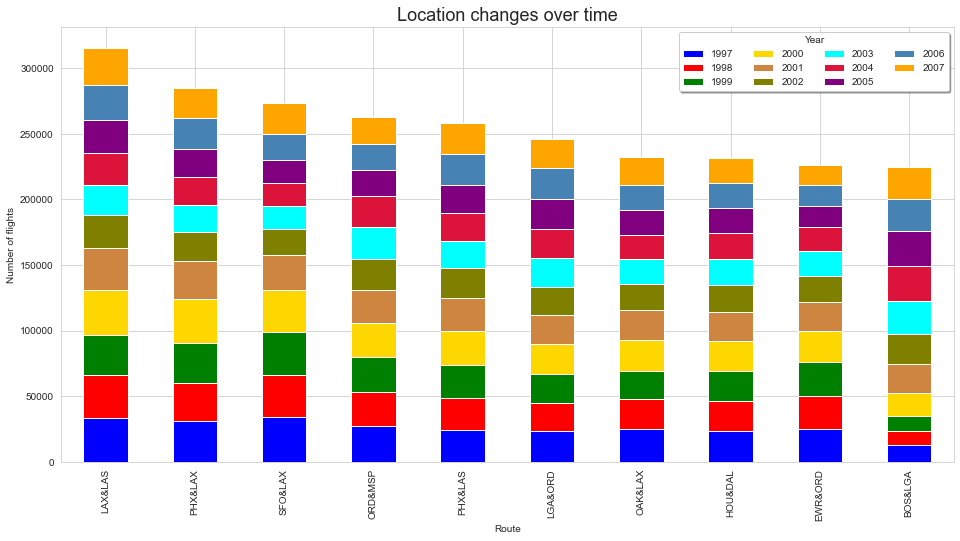

In [83]:
#plot 11 year stacked
f, ax = plt.subplots(figsize=(16, 8))


colors=['blue','red','green','gold','peru','olive','cyan',
        'crimson','purple','steelblue','orange'] #colour
top10.set_index('Route').plot(kind='bar', stacked=True,ax=ax,color=colors) #plot
ax.legend(loc='upper right',title='Year', bbox_to_anchor=(1, 1),
          ncol=4, fancybox=True, shadow=True) #legend
plt.title('Location changes over time', fontsize=18) #title
plt.ylabel('Number of flights') #ylabel
plt.show()

Plot of years that stand out a bit (including start and end year)

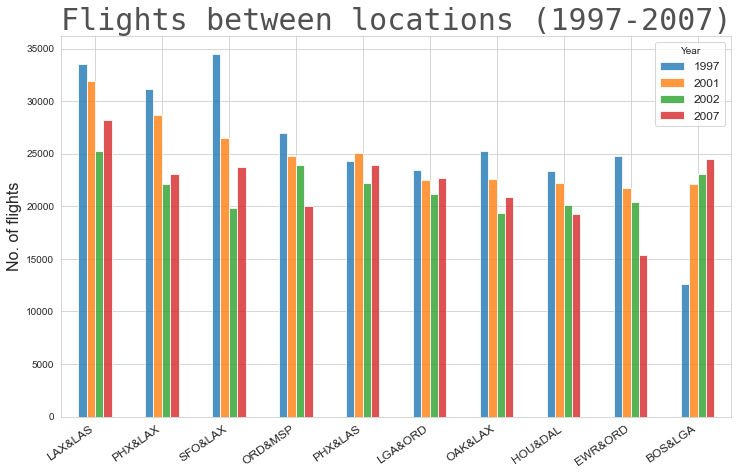

In [84]:
#data prep
start_to_end = top10[['Route','1997','2001','2002','2007']]

#reset plot style for next to plots (to match color of bars)
sns.reset_orig()
sns.set_style("whitegrid")

#plot
f,ax=plt.subplots(figsize=(12,7))
start_to_end.set_index('Route').plot(kind='bar',stacked=False,ax=ax, alpha=.8)
ax.legend(loc='upper right', title='Year', fontsize=12) #legend
#title and labels,etc:
ax.set_title('Flights between locations (1997-2007)', fontsize=30, fontname="Monospace", alpha=.8)
ax.set_xlabel(xlabel=None) #remove obvioius xlabel
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right", fontsize = 12) #rotate xlabel
ax.set_ylabel('No. of flights', fontsize=16) #ylab
plt.savefig('Q3_plot1.png', bbox_inches='tight') #export png
plt.show() 

In [85]:
#set plotting style for following plots in notebook
sns.reset_orig()
plt.style.use('seaborn-colorblind')
sns.set_style("whitegrid")

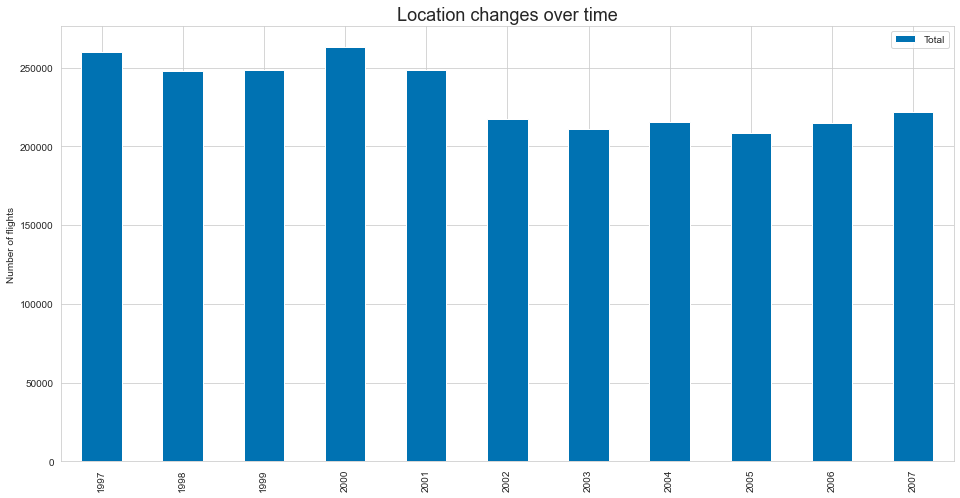

In [86]:
#plot total flights over the years

#data prep
top10_tot = top10 
top10_tot.loc['Total']= top10_tot.sum(numeric_only=True,axis=0)
top10_tot = top10_tot.fillna('All Routes')
tot10_tot_data = top10_tot.iloc[10,1:12]
tot10_tot_data = pd.DataFrame(tot10_tot_data)

#plot
f, ax = plt.subplots(figsize=(16, 8))
tot10_tot_data.plot(kind='bar',ax=ax,color=palette)
plt.title('Location changes over time', fontsize=18)
plt.ylabel('Number of flights')
plt.show()

The no. of people flying between locations in the last 10 year have generally fallen between most locations. The no. of people flying is increasing again since 2002. Flights between Boston Logan and LaGuardia in New York has increased quite a bit from 1997 to 2007. There is a noticeabledrop around 2001 - it may likely be due to 9/11, lets explore the data further:

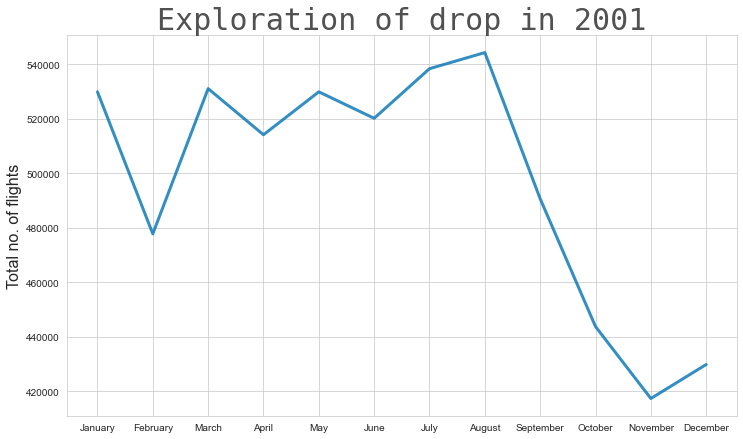

In [87]:
#Exploration of the drop in 2001
df_2001 = pd.read_csv("2001.csv", usecols = ["Month", "UniqueCarrier"], encoding='latin-1') #read data
df_2001 = df_2001.groupby("Month").count().reset_index(drop=False) #count flights per month
df_2001['Month'] = df_2001['Month'].map({1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}).astype('str') #map names of months

#plot data
f,ax=plt.subplots(figsize=(12,7))
ax.plot(df_2001['Month'], df_2001['UniqueCarrier'], alpha=0.8,linewidth=3)
plt.title("Exploration of drop in 2001", fontsize=30, fontname="Monospace", alpha=.8)
ax.set_xlabel(xlabel=None) #remove obvioius xlabel
plt.ylabel('Total no. of flights', fontsize=16)
plt.savefig('Q3_plot2.png', bbox_inches='tight')
plt.show()


We can see that the drop in 2001 is around the 9/11. It seems to have a big impact on the industry going forward. Similar should also be happening in 2020 due to Covid-19.

### Question 4.4

4. Can you detect cascading failures as delays in one airport create delays in others

In [88]:
#create df's
plane_delay = df #df for airplanes
df_airport = df #df for airports

#select columns
plane_delay= plane_delay[['TailNum','Origin','Dest','DepDelay','ArrDelay','Date','DepTime']]
df_airport = df_airport[['Origin','DepDelay','Dest','DepTime','ArrDelay','Date_bin','Month','DayofMonth','dep_hour_int']]

#create column with boolean delay occurence value
def label4 (row): 
    if row <= 0: return 0
    if row > 0: return 1
plane_delay['DepDelay']=plane_delay['DepDelay'].apply(label4) #apply condition
plane_delay['ArrDelay']=plane_delay['ArrDelay'].apply(label4) #apply condition
df_airport['DepDelay']=df_airport['DepDelay'].apply(label4) #apply condition
df_airport['ArrDelay']=df_airport['ArrDelay'].apply(label4) #apply condition

plane_delay #explore df, we use df_airport later.

C:\Users\e2u\AppData\Local\Temp/ipykernel_28964/2934224347.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plane_delay['DepDelay']=plane_delay['DepDelay'].apply(label4) #apply condition
C:\Users\e2u\AppData\Local\Temp/ipykernel_28964/2934224347.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plane_delay['ArrDelay']=plane_delay['ArrDelay'].apply(label4) #apply condition
C:\Users\e2u\AppData\Local\Temp/ipykernel_28964/2934224347.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy o

,TailNum,Origin,Dest,DepDelay,ArrDelay,Date,DepTime
0,N657AW,ATL,PHX,0,1,2006-01-11 07:43:00.740280000,743.0
1,N834AW,ATL,PHX,0,0,2006-01-11 10:56:11.627880000,1053.0
2,N605AW,ATL,PHX,0,0,2006-01-11 19:53:21.773400000,1915.0
3,N312AW,AUS,PHX,0,0,2006-01-11 18:12:24.599880000,1753.0
4,N309AW,AUS,PHX,0,0,2006-01-11 08:33:29.327040000,824.0
...,...,...,...,...,...,...,...
14007599,85019E,RIC,MSP,1,1,2007-02-11 06:35:05.234639999,634.0
14007600,88849E,LNK,MSP,0,0,2007-01-12 13:30:06.948000000,1300.0
14007601,89249E,ELM,DTW,0,0,2007-12-25 09:55:07.411800000,955.0
14007602,89339E,DTW,SGF,0,0,2007-10-16 15:49:42.299040000,1524.0


In [89]:
plane_delay['TailNum'].value_counts()

N308SW    8461
N478HA    8047
N479HA    7919
N480HA    7919
N485HA    7892
          ... 
N297         2
N857NW       1
N78009       1
N623US       1
N194JB       1
Name: TailNum, Length: 5811, dtype: int64

In [90]:
#select plane
plane_delay_N485HA = plane_delay.loc[plane_delay['TailNum'] == 'N485HA'].sort_values(by=['Date'])
plane_delay_N485HA #explore

,TailNum,Origin,Dest,DepDelay,ArrDelay,Date,DepTime
9260923,N485HA,HNL,LIH,0,0,2006-01-01 07:32:25.110960,726.0
9260954,N485HA,LIH,HNL,0,0,2006-01-01 08:35:58.886880,828.0
9263215,N485HA,HNL,OGG,0,0,2006-01-01 09:32:41.373240,919.0
9263246,N485HA,OGG,HNL,0,0,2006-01-01 10:39:59.488920,1027.0
9261787,N485HA,HNL,ITO,0,0,2006-01-01 11:46:02.824680,1133.0
...,...,...,...,...,...,...,...
9321650,N485HA,OGG,HNL,0,0,2007-12-31 15:05:27.611880,1453.0
9323236,N485HA,HNL,ITO,0,0,2007-12-31 16:10:53.557680,1558.0
9314354,N485HA,ITO,HNL,0,0,2007-12-31 17:47:29.001480,1713.0
9336290,N485HA,HNL,OGG,0,0,2007-12-31 19:10:59.256120,1847.0


In [91]:
#detect cascading failures
plane_delay_N485HA = plane_delay_N485HA[['TailNum','DepDelay','ArrDelay']] #columns to use

#count consecutive delays

#departure casc. failure: departure delay in A + arrival delay in B + departure delay on next flight C
plane_delay_N485HA['dep_casc']=plane_delay_N485HA['DepDelay']+plane_delay_N485HA['ArrDelay']+plane_delay_N485HA['DepDelay'].shift(1)

#departure casc. failure: arrival delay in A + departure delay in B + arrival delay on next flight C
plane_delay_N485HA['arr_casc']=plane_delay_N485HA['ArrDelay']+plane_delay_N485HA['DepDelay']+plane_delay_N485HA['ArrDelay'].shift(1)

#when a cascading delay has occured, dep_casc or arr_casc is = 3
plane_delay_N485HA2 = plane_delay_N485HA[(plane_delay_N485HA["dep_casc"] == 3.0) | (plane_delay_N485HA["arr_casc"] == 3.0)]

#count occurences
plane_delay_N485HA2 =plane_delay_N485HA2.groupby("TailNum").count().reset_index(drop=False)
plane_delay_N485HA2 = plane_delay_N485HA2[['TailNum','arr_casc']] #sort
plane_delay_N485HA2.rename(columns={'arr_casc': 'Cascading Failures'}, inplace=True) #rename
plane_delay_N485HA2 #explore

C:\Users\e2u\AppData\Local\Temp/ipykernel_28964/1417509931.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plane_delay_N485HA['dep_casc']=plane_delay_N485HA['DepDelay']+plane_delay_N485HA['ArrDelay']+plane_delay_N485HA['DepDelay'].shift(1)
C:\Users\e2u\AppData\Local\Temp/ipykernel_28964/1417509931.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plane_delay_N485HA['arr_casc']=plane_delay_N485HA['ArrDelay']+plane_delay_N485HA['DepDelay']+plane_delay_N485HA['ArrDelay'].shift(1)


,TailNum,Cascading Failures
0,N485HA,568


In [92]:
#add a second plane to the table

#create df with N477HA flight
plane_delay_N477HA = plane_delay.loc[plane_delay['TailNum'] == 'N477HA'].sort_values(by=['Date'])
plane_delay_N477HA = plane_delay_N477HA[['TailNum','DepDelay','ArrDelay']]
plane_delay_N477HA['dep_casc']=plane_delay_N477HA['DepDelay']+plane_delay_N477HA['ArrDelay']+plane_delay_N477HA['DepDelay'].shift(1)
plane_delay_N477HA['arr_casc']=plane_delay_N477HA['ArrDelay']+plane_delay_N477HA['DepDelay']+plane_delay_N477HA['ArrDelay'].shift(1)

#df for table
plane_delay_N477HA2 = plane_delay_N477HA[(plane_delay_N477HA["dep_casc"] == 3.0) | (plane_delay_N477HA["arr_casc"] == 3.0)]
plane_delay_N477HA2=plane_delay_N477HA2.groupby("TailNum").count().reset_index(drop=False)
plane_delay_N477HA2 = plane_delay_N477HA2[['TailNum','arr_casc']]
plane_delay_N477HA2.rename(columns={'arr_casc': 'Cascading Failures'}, inplace=True)

two_tails = pd.concat([plane_delay_N485HA2, plane_delay_N477HA2])
two_tails=two_tails.reset_index(drop=True)
two_tails

,TailNum,Cascading Failures
0,N485HA,568
1,N477HA,485


In [93]:
#count departure and arrival delays
print(plane_delay_N477HA['DepDelay'][(plane_delay_N477HA["DepDelay"] == 1)].count())
print(plane_delay_N477HA['DepDelay'][(plane_delay_N477HA["DepDelay"] == 1) & (plane_delay_N477HA["ArrDelay"] == 1)].count())

#count departure and arrival delays
print(plane_delay_N485HA['DepDelay'][(plane_delay_N485HA["DepDelay"] == 1)].count())
print(plane_delay_N485HA['DepDelay'][(plane_delay_N485HA["DepDelay"] == 1) & (plane_delay_N485HA["ArrDelay"] == 1)].count())

801
684
939
791


In [94]:
#cascading fail / tailnum with initial delay and delay in A and B airports.
N477 = (487/805)*100
N477_B =(487/687)*100
N477_tot =(487/7696)*100

N485 = (564/937)*100
N485_b =(564/788)*100 
N485_tot =(564/7893)*100

print("N477HA with delay in airport A has:", N477, "% cascading delay failures")
print("N477HA with delay in airport A and B has:", N477_B , "% cascading delay failures")
print("N477HA has a cascading delay in totl:", N477_tot , "% of flights")


print("N485HA with delay in airport A has:", N485, "% cascading delay failures")
print("N485HA with delay in airport A and B has:", N485_b, "% cascading delay failures")
print("N477HA has a cascading delay in totl:", N485_tot , "% of flights")

N477HA with delay in airport A has: 60.49689440993789 % cascading delay failures
N477HA with delay in airport A and B has: 70.88791848617177 % cascading delay failures
N477HA has a cascading delay in totl: 6.327962577962578 % of flights
N485HA with delay in airport A has: 60.19210245464247 % cascading delay failures
N485HA with delay in airport A and B has: 71.57360406091371 % cascading delay failures
N477HA has a cascading delay in totl: 7.145572025845687 % of flights


In [95]:
#create table with all stats
N485HA_1 = [7893]
N485HA_col = ['N485HA','Flights']
N485HA_df = pd.DataFrame(list(zip(N485HA_col,N485HA_1)), columns=[1,2]).explode(2).reset_index(drop=True)
N485HA_df.rename(columns={1:'TailNum' ,2: 'Flights'}, inplace=True)

N477HA_1 = [7696]
N477HA_col = ['N477HA','Flights']
N477HA_df = pd.DataFrame(list(zip(N477HA_col,N477HA_1)), columns=[1,2]).explode(2).reset_index(drop=True)
N477HA_df.rename(columns={1:'TailNum' ,2: 'Flights'}, inplace=True)

two_tails_2 = pd.concat([N485HA_df, N477HA_df],ignore_index=True)

two_tails_3 = pd.merge(two_tails, two_tails_2,  how='inner', left_on=['TailNum'], right_on = ['TailNum'])

two_tails_3['Casc. Failure (%)'] = two_tails_3['Cascading Failures']/two_tails_3['Flights']*100
two_tails_3 = two_tails_3[['TailNum','Flights','Cascading Failures','Casc. Failure (%)']]

#export cell (dataframe_image library)
two_tails_style2 = two_tails_3.style.background_gradient()
dfi.export(two_tails_style2,"Q4_table1.png")
two_tails_style2

,TailNum,Flights,Cascading Failures,Casc. Failure (%)
0,N485HA,7893,568,7.196250
1,N477HA,7696,485,6.301975


We can see that when the plane with tailnumber 'N485HA' has a delay in the origin airport, it creates a delay on its own next flight in appox 6% of the cases.
We can see that when the plane with tailnumber 'N485HA' has a delay in the origin airport, it creates a delay on its next flight in appox 13% of the cases.

We can also detect if a delay generates delays for the following flights in the same airport and route, Las Vegas (A) to Los Angeles (B) and ending in Las Vegas again (C):

In [96]:
#explore the df we created for airports earlier
df_airport

,Origin,DepDelay,Dest,DepTime,ArrDelay,Date_bin,Month,DayofMonth,dep_hour_int
0,ATL,0,PHX,743.0,1,2006-01-11 07:00:00,January,11,7
1,ATL,0,PHX,1053.0,0,2006-01-11 10:00:00,January,11,10
2,ATL,0,PHX,1915.0,0,2006-01-11 19:00:00,January,11,19
3,AUS,0,PHX,1753.0,0,2006-01-11 17:00:00,January,11,17
4,AUS,0,PHX,824.0,0,2006-01-11 08:00:00,January,11,8
...,...,...,...,...,...,...,...,...,...
14007599,RIC,1,MSP,634.0,1,2007-02-11 06:00:00,February,11,6
14007600,LNK,0,MSP,1300.0,0,2007-01-12 13:00:00,January,12,13
14007601,ELM,0,DTW,955.0,0,2007-12-25 09:00:00,December,25,9
14007602,DTW,0,SGF,1524.0,0,2007-10-16 15:00:00,October,16,15


In [97]:
#create a time bin column
#choose 3 hours because the flight of interest LAS-LAX is approx. 1h15m, so with delays 
#and a windows to see the potential effects, hence a 3 hour bin seems reasonable.
def label5 (row): 
    if row >= 0 and row <=3: return '00-03'
    if row > 3 and row <=6: return '03-06'
    if row > 6 and row <=9: return '06-09'
    if row > 9 and row <=12: return '09-12'
    if row > 12 and row <=15: return '12-15'
    if row > 15 and row <=18: return '15-18'
    if row > 18 and row <=21: return '18-21'
    if row > 21 and row <=24: return '21-24'

df_airport['time_range_3hour']=df_airport['dep_hour_int'].apply(label5) #apply condition
df_airport

C:\Users\e2u\AppData\Local\Temp/ipykernel_28964/1333339997.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_airport['time_range_3hour']=df_airport['dep_hour_int'].apply(label5) #apply condition


,Origin,DepDelay,Dest,DepTime,ArrDelay,Date_bin,Month,DayofMonth,dep_hour_int,time_range_3hour
0,ATL,0,PHX,743.0,1,2006-01-11 07:00:00,January,11,7,06-09
1,ATL,0,PHX,1053.0,0,2006-01-11 10:00:00,January,11,10,09-12
2,ATL,0,PHX,1915.0,0,2006-01-11 19:00:00,January,11,19,18-21
3,AUS,0,PHX,1753.0,0,2006-01-11 17:00:00,January,11,17,15-18
4,AUS,0,PHX,824.0,0,2006-01-11 08:00:00,January,11,8,06-09
...,...,...,...,...,...,...,...,...,...,...
14007599,RIC,1,MSP,634.0,1,2007-02-11 06:00:00,February,11,6,03-06
14007600,LNK,0,MSP,1300.0,0,2007-01-12 13:00:00,January,12,13,12-15
14007601,ELM,0,DTW,955.0,0,2007-12-25 09:00:00,December,25,9,06-09
14007602,DTW,0,SGF,1524.0,0,2007-10-16 15:00:00,October,16,15,12-15


In [98]:
#select two big airports (LAS VEGAS AND LOS ANGELES)

#Las Vegas
df_LAS = df_airport.loc[(df_airport['Origin'] == 'LAS') & (df_airport['Dest'] == 'LAX')] #only the two
df_LAS = df_LAS[['Origin','DepDelay','Dest','DepTime',
                 'ArrDelay','Date_bin','Month','DayofMonth',
                 'dep_hour_int','time_range_3hour']] #select columns
df_LAS = df_LAS.sort_values('Date_bin') #sort
#add one hour to see how the flight affect following delays in B (dep) and C (arr)
#becauase the flight is approx. 1.15m
df_LAS['Date_bin'] = df_LAS['Date_bin']+timedelta(hours=1) #add one hour to all
#delay in airport A
df_LAS_tot = df_LAS[(df_LAS["ArrDelay"] == 1)]
df_LAS_tot = df_LAS_tot.groupby('Date_bin').count() #the bin with +1H grouped 
df_LAS_tot = df_LAS_tot.reset_index(drop=False)
df_LAS_tot = df_LAS_tot[['Date_bin','DepDelay']]
#rename DepDelay to delay because all counts are where arrdelay is == 1.
df_LAS_tot.rename(columns={'DepDelay':'Delay'}, inplace=True) 

#Los Angeles
df_LAX = df_airport.loc[(df_airport['Origin'] == 'LAX') & (df_airport['Dest'] == 'LAS')] #only the two
df_LAX = df_LAX[['Origin','DepDelay','Dest','DepTime',
                 'ArrDelay','Date_bin','Month','DayofMonth',
                 'dep_hour_int','time_range_3hour']] #columns for LA
df_LAX = df_LAX.sort_values('Date_bin') #sort
#delay for airport B AND C
df_LAX_tot = df_LAX[(df_LAX["DepDelay"] == 1) & (df_LAX["ArrDelay"] == 1)] 
df_LAX_tot = df_LAX_tot.groupby('Date_bin').count() #group and count
df_LAX_tot = df_LAX_tot.reset_index(drop=False)
df_LAX_tot = df_LAX_tot[['Date_bin','DepDelay']] #we dont't need all colums because we only have datapoints where both DepDelay and ArrDelay are true.
df_LAX_tot.rename(columns={'DepDelay':'Delay'}, inplace=True) #rename, delay = both dep and arrdeay has occured.

#merge on the datebin that is matched to reflect cascading failures
las_lax_ABA = pd.merge(df_LAX_tot, df_LAS_tot, on='Date_bin')

#only select where Delay_x(delay in both airport B&C) is equal or more than Delay_y(delay in airport A): 
#otherwise we are just counting the no. of delays in airport A for the particular dataset.
las_lax_ABA = las_lax_ABA[(las_lax_ABA["Delay_x"] >= las_lax_ABA["Delay_y"])] #condition on B&C
las_lax_ABA_sum = las_lax_ABA["Delay_y"].sum()
print("sum Delay_y :", las_lax_ABA["Delay_y"].sum())
las_lax_ABA

sum Delay_y : 3685


,Date_bin,Delay_x,Delay_y
0,2006-01-01 08:00:00,1,1
2,2006-01-01 12:00:00,2,2
3,2006-01-01 13:00:00,2,2
4,2006-01-01 15:00:00,1,1
5,2006-01-01 17:00:00,4,2
...,...,...,...
4557,2007-12-31 10:00:00,3,1
4558,2007-12-31 11:00:00,2,2
4559,2007-12-31 16:00:00,1,1
4560,2007-12-31 17:00:00,1,1


In [125]:
#create table with dummy vaiables
chart_df = df_LAX.reset_index(drop=True).merge(df_LAS.reset_index(drop=True), left_index=True, right_index=True)
print("total flights on route: ",chart_df.shape[0])

#use dummy columns and create a table with cascading delays failures detected
las_lax_chart = chart_df[['Origin_y','Origin_x','Dest_x']] #dumme variable
las_lax_chart.rename(columns={'Origin_y': 'Airport A','Origin_x':'Airport B','Dest_x':
                              'Airport C'}, inplace=True) #rename
las_lax_chart['Cascading failures']=3685 #casc. detected
las_lax_chart=las_lax_chart.head(1)
las_lax_chart['Flights'] = 26033 #total flights
las_lax_chart['Casc. Failure (%)'] = las_lax_chart['Cascading failures']/las_lax_chart['Flights']*100
las_lax_chart_style = las_lax_chart[['Airport A' ,'Airport B','Airport C','Flights',
                                     'Cascading failures','Casc. Failure (%)']] #columns
las_lax_chart_style = las_lax_chart_style.style.background_gradient() #style
dfi.export(las_lax_chart_style,"Q4_table2.png") #export
las_lax_chart_style #explore

total flights on route:  26033


C:\Users\e2u\AppData\Local\Temp/ipykernel_28964/3814872840.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  las_lax_chart['Cascading failures']=3685 #casc. detected


,Airport A,Airport B,Airport C,Flights,Cascading failures,Casc. Failure (%)
0,LAS,LAX,LAS,26033,3685,14.155111


We can detect 3708 cascading failures as delay, there is a departure delay in LAS (airport A), then also a departure delay airports LAX (airport B), and finally a arrival delay in LAX again (airport C)


Not surprisingly, the same route is quite affected by consecutive delays! Let's look at how a flight fom LAS (A) to LAX (B) creates delays for all other airports in the time range (C):

In [100]:
#we se the LAS df again for the first flights.
#for the next two destinations we create a new df starting in LAX:
df_LAX_all = df_airport.loc[(df_airport['Origin'] == 'LAX')] #las vegas (dest =all others.)
df_LAX_all = df_LAX_all[['Origin','DepDelay','Dest','DepTime','ArrDelay','Date_bin','Month','DayofMonth','dep_hour_int','time_range_3hour']]
df_LAX_all = df_LAX_all.sort_values('Date_bin')

#delay in airport B AND C
df_LAX_tot = df_LAX_all[(df_LAX_all["DepDelay"] == 1) & (df_LAX_all["ArrDelay"] == 1)] 
df_LAX_tot = df_LAX_tot.groupby('Date_bin').count()
df_LAX_tot = df_LAX_tot.reset_index(drop=False)
df_LAX_tot = df_LAX_tot[['Date_bin','DepDelay']] #we dont't need all colums because we only have datapoints where both DepDelay and ArrDelay are true.
df_LAX_tot.rename(columns={'DepDelay':'Delay'}, inplace=True) #rename, delay = both dep and arrdeay has occured.

#merge with flight from LAS (A) on the datebin 
las_lax_ABC = pd.merge(df_LAX_tot, df_LAS_tot, on='Date_bin')

#select where Delay_x is bigger/equal than Delay_y only.
las_lax_ABC = las_lax_ABC[(las_lax_ABC["Delay_x"] >= las_lax_ABC["Delay_y"])] #condition on B&C
las_lax_ABC_sum = las_lax_ABC["Delay_y"].sum()
print("sum Delay_y :", las_lax_ABC["Delay_y"].sum())
las_lax_ABC


sum Delay_y : 12903


,Date_bin,Delay_x,Delay_y
0,2006-01-01 01:00:00,2,1
1,2006-01-01 08:00:00,12,1
2,2006-01-01 09:00:00,13,2
3,2006-01-01 11:00:00,11,3
4,2006-01-01 12:00:00,22,2
...,...,...,...
8239,2007-12-31 16:00:00,18,1
8240,2007-12-31 17:00:00,16,1
8241,2007-12-31 18:00:00,9,1
8242,2007-12-31 21:00:00,3,1


In [124]:
#create table with dummy vaiables
chart_df2 = df_LAX_all.reset_index(drop=True).merge(df_LAS.reset_index(drop=True), left_index=True, right_index=True)
print("total flights on route: ",df_LAX_all.shape[0]) #get total flights no.

#use dummy columns and create a table with cascading delays failures detected
las_all_chart = chart_df[['Origin_y','Origin_x','Dest_x']] #dumme variable
las_all_chart.rename(columns={'Origin_y': 'Airport A','Origin_x':'Airport B','Dest_x':
                              'Airport C'}, inplace=True) #rename
las_all_chart['Cascading failures']=12903 #casc. detected
las_all_chart=las_all_chart.head(1)
las_all_chart['Flights'] = 455728 #total flights from LAX
las_all_chart['Casc. Failure (%)'] = las_all_chart['Cascading failures']/las_all_chart['Flights']*100
las_all_chart = las_all_chart[['Airport A' ,'Airport B','Airport C','Flights',
                                     'Cascading failures','Casc. Failure (%)']] #columns
#set rowname in Airport C
#def label6 (row):
 #  if row['Airport C'] != 'Lego City Airport':
  #    return 'All other airports'
#las_all_chart['Airport C']=las_all_chart.apply(lambda row: label6(row), axis=1)
las_all_chart['Airport C']='All other airports' #function is not neccesary.

#table style
las_all_chart_style = las_all_chart.style.background_gradient() #style
dfi.export(las_all_chart_style,"Q4_table3.png") #export
las_all_chart_style #explore

total flights on route:  455728


C:\Users\e2u\AppData\Local\Temp/ipykernel_28964/3069650581.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  las_all_chart['Cascading failures']=12903 #casc. detected


,Airport A,Airport B,Airport C,Flights,Cascading failures,Casc. Failure (%)
0,LAS,LAX,All other airports,455728,12903,2.831294


We can detect 12873 cascading delay failures that starts in airport A and affect both airport B and C thereon, approx 2.83%, hence a lot less than for the same route.

We could also try to make a model that predicts cascading delay failures

In [102]:
#merge the df's
airplane_ml =df_LAX_all.reset_index(drop=True).merge(df_LAS.reset_index(drop=True), left_index=True, right_index=True)
airplane_ml = airplane_ml[['Origin_x','Dest_x','DepDelay_x','ArrDelay_x','Month_x','DayofMonth_x','dep_hour_int_x','Origin_y','Dest_y','DepDelay_y','ArrDelay_y','Month_y','DayofMonth_y','dep_hour_int_y']]
airplane_ml['Month_x'] = airplane_ml['Month_x'].map({'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12})
airplane_ml['Month_y'] = airplane_ml['Month_y'].map({'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12})
airplane_ml

,Origin_x,Dest_x,DepDelay_x,ArrDelay_x,Month_x,DayofMonth_x,dep_hour_int_x,Origin_y,Dest_y,DepDelay_y,ArrDelay_y,Month_y,DayofMonth_y,dep_hour_int_y
0,LAX,MSP,1,1,1,1,0,LAS,LAX,1,1,1,1,0
1,LAX,CLE,1,1,1,1,0,LAS,LAX,0,0,1,1,6
2,LAX,DFW,0,0,1,1,0,LAS,LAX,0,0,1,1,6
3,LAX,ATL,0,0,1,1,0,LAS,LAX,0,0,1,1,7
4,LAX,TPA,1,1,1,1,0,LAS,LAX,0,1,1,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26028,LAX,SAN,0,0,2,13,7,LAS,LAX,1,0,12,31,18
26029,LAX,ORD,1,0,2,13,7,LAS,LAX,0,0,12,31,18
26030,LAX,YUM,0,0,2,13,7,LAS,LAX,1,1,12,31,20
26031,LAX,SBP,0,0,2,13,7,LAS,LAX,1,1,12,31,21


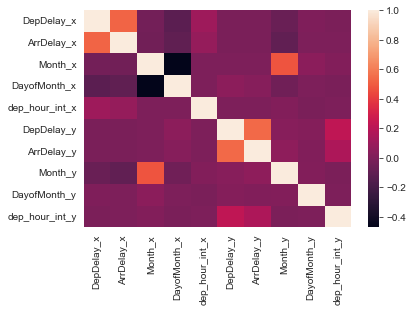

In [103]:
#correlation heatmap
airplane_ml_heatm = sns.heatmap(airplane_ml.corr()) #plot the heatmap
airplane_ml_heatm
airplane_ml_heatm.figure.savefig("Q4_plot2.png")

In [104]:
airplane_ml = pd.get_dummies(airplane_ml, columns=['Origin_x', 'Dest_x','Origin_y', 'Dest_y'])

#split into training and test set(80/20)
from sklearn.model_selection import train_test_split #import train_test_split function
X_train_cas, X_test_cas, y_train_cas, y_test_cas = train_test_split(airplane_ml.drop('ArrDelay_y', axis=1), airplane_ml['ArrDelay_y'], test_size=0.2, random_state=42)

In [105]:
#import librarys and classifier
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

#create model
model_cas = RandomForestClassifier(random_state=42)#42: ultimate question of life, the universe, and everything
model_cas.fit(X_train_cas, y_train_cas)

#probability and predictions
prob_cas = model_cas.predict_proba(X_test_cas)
train_pred_cas = model_cas.predict(X_train_cas)
pred_cas = model_cas.predict(X_test_cas)

#print scores:
print('Prediction: {:.5f}'.format(model_cas.score(X_test_cas, y_test_cas)))
print('Accuracy: {:.5f}'.format(accuracy_score(y_test_cas, pred_cas)))
print('Precision: {:.5f}'.format(precision_score(y_train_cas, train_pred_cas)))
print('Recall: {:.5f}'.format(recall_score(y_test_cas, pred_cas)))


Prediction: 0.76704
Accuracy: 0.76704
Precision: 0.99866
Recall: 0.74526


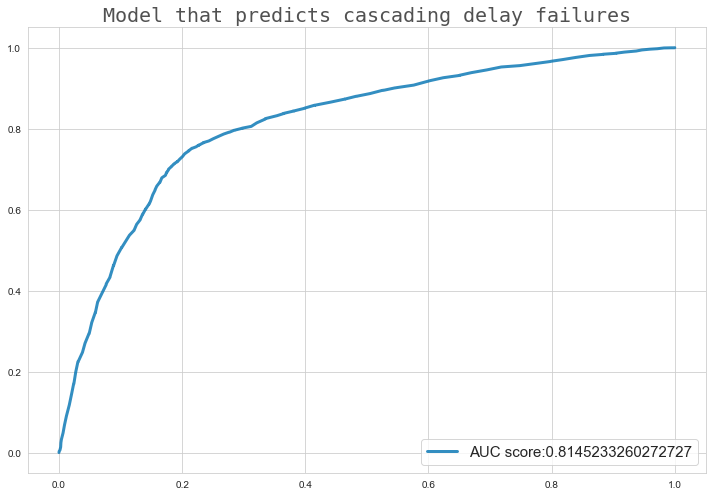

In [106]:
#plot 
from sklearn import metrics

y_pred_proba = model_cas.predict_proba(X_test_cas)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_cas,  y_pred_proba)
auc = metrics.roc_auc_score(y_test_cas, y_pred_proba)

f, ax = plt.subplots(figsize=(10, 7))
plt.plot(fpr,tpr,label="AUC score:"+str(auc), alpha=0.8,linewidth=3)
plt.legend(loc=4, fontsize =15)
ax.set_title('Model that predicts cascading delay failures', fontsize=20, fontname="Monospace", alpha=.8)
plt.tight_layout(rect=[0, 0, 1, 1]) #tight layout#tight layout
plt.savefig('Q4_plot1.png', bbox_inches='tight')
plt.show() #plot

### Question 4.5


5. Use the available variables to construct a model that predicts delays:


In [107]:
ml1 = pd.read_csv("2006.csv")
ml2 = pd.read_csv("2007.csv")
#ml3 = pd.read_csv("2008.csv") #ignore data due to missing months

#if a flight is cancelled, then delay entry shouldn't be possible
ml1=ml1[ml1['Cancelled']==0] #select only not cancelled flights for 2007.
ml2=ml2[ml2['Cancelled']==0] #select only not cancelled flights for 2008.
ml1=ml1[ml1['Diverted']==0] #select only not diverted flights for 2007.
ml2=ml2[ml2['Diverted']==0] #select only not diverted flights for 2008.

print(ml1.shape)
print(ml2.shape)

(7003802, 29)
(7275288, 29)


In [108]:
#take sample to match datapoints (avoid bias)
ml2 = ml2.sample(7019988)
print(ml2.shape)
#combine data
ml = pd.concat([ml1, ml2],ignore_index=True) #combine dataframes
#create a total delay column
ml['delay_total']= (ml['ArrDelay']+ml['DepDelay'])
#change timeformat of the 'CRSDepTime' column
ml['CRSDepTime']=(ml['CRSDepTime']/100)
ml['CRSArrTime']=(ml['CRSArrTime']/100)
#create delay column with multiclass values.
delay =[]
for row in ml['delay_total']:
    if row > 45:
        delay.append(2)    #more than 45 min late (total delay)
    elif row < 45:  
        delay.append(1)    #less than 45 min late (total delay)
    else:
        delay.append(0)    #ontime or arriving before time (total delay)
ml['delay'] = delay 

ml #explore data

(7019988, 29)


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_total,delay
0,2006,1,11,3,743.0,7.45,1024.0,10.18,US,343,...,0,NaN,0,0,0,0,0,0,4.0,1
1,2006,1,11,3,1053.0,10.53,1313.0,13.18,US,613,...,0,NaN,0,0,0,0,0,0,-5.0,1
2,2006,1,11,3,1915.0,19.15,2110.0,21.33,US,617,...,0,NaN,0,0,0,0,0,0,-23.0,1
3,2006,1,11,3,1753.0,17.55,1925.0,19.33,US,300,...,0,NaN,0,0,0,0,0,0,-10.0,1
4,2006,1,11,3,824.0,8.32,1015.0,10.15,US,765,...,0,NaN,0,0,0,0,0,0,-8.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14023785,2007,9,12,3,1626.0,16.30,1936.0,19.11,US,1928,...,0,NaN,0,0,0,25,0,0,21.0,1
14023786,2007,11,5,1,939.0,9.40,1057.0,11.15,XE,2241,...,0,NaN,0,0,0,0,0,0,-19.0,1
14023787,2007,9,15,6,943.0,9.35,1642.0,16.39,DL,973,...,0,NaN,0,0,0,0,0,0,11.0,1
14023788,2007,8,22,3,2119.0,18.40,2248.0,20.05,WN,2969,...,0,NaN,0,0,0,159,0,4,322.0,2


In [109]:
#no. of total delays above 45 min(2), delays below 45 min (1), and on time or arriving before (0)
ml.value_counts('delay')

delay
1    11719876
2     2265920
0       37994
dtype: int64

In [110]:
#slect relevant columns & check for NA's
ml = ml[['Month','DayOfWeek','DayofMonth','Origin','Dest','CRSDepTime','DepDelay','CRSArrTime','ArrDelay','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay','delay']]
ml.isnull().sum()

Month                0
DayOfWeek            0
DayofMonth           0
Origin               0
Dest                 0
CRSDepTime           0
DepDelay             0
CRSArrTime           0
ArrDelay             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
delay                0
dtype: int64

<AxesSubplot:>

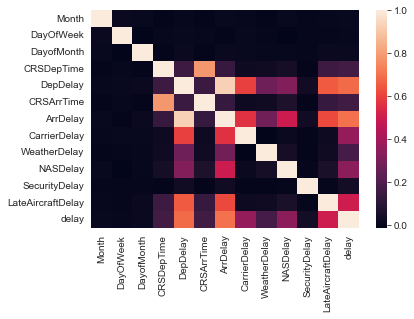

In [111]:
#correlation heatmap
import seaborn as sns #imports the seaborn library
sns.heatmap(ml.corr()) #plot the heatmap

In [112]:
#take a sample of the data (due to computational limitations)
ml=ml.sample(250000)

#dummies from orgigin and dest columns
ml = pd.get_dummies(ml, columns=['Origin', 'Dest'])
ml.head()

,Month,DayOfWeek,DayofMonth,CRSDepTime,DepDelay,CRSArrTime,ArrDelay,CarrierDelay,WeatherDelay,NASDelay,...,Dest_TYR,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM
8613936,12,3,5,13.10,0.0,14.35,8.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7895367,2,7,4,12.25,13.0,15.11,5.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11688549,12,1,24,20.45,-4.0,21.57,-16.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3722269,7,6,15,15.35,103.0,16.44,103.0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
954021,2,1,6,12.55,4.0,13.35,-7.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
#split into training and test set(80/20)
from sklearn.model_selection import train_test_split #import  function
X_train, X_test, y_train, y_test = train_test_split(ml.drop('delay', axis=1), ml['delay'], test_size=0.2, random_state=42)

### Model 1: Gradient Boosting Classifier

In [114]:
#import librarys and classifier
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

#create model
model1 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=1, random_state=0).fit(X_train, y_train)

#probability and predictions
prob1 = model1.predict_proba(X_test)
train_pred1 = model1.predict(X_train)
pred1 = model1.predict(X_test)

#print scores:
print('Prediction: {:.5f}'.format(model1.score(X_test, y_test)))
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, pred1)))
print('AUC score: {:.5f}'.format(roc_auc_score(y_test, prob1, multi_class='ovr')))
print('Precision: {:.5f}'.format(precision_score(y_train, train_pred1, average='micro')))
print('Recall: {:.5f}'.format(recall_score(y_test, pred1, average='micro')))

Prediction: 0.96592
Accuracy: 0.96592
AUC score: 0.92368
Precision: 0.96483
Recall: 0.96592


### Model 2: Random Forest Classifier

In [115]:
#import classifier
from sklearn.ensemble import RandomForestClassifier

#create model
model2 = RandomForestClassifier(random_state=42)#42: ultimate question of life, the universe, and everything
model2.fit(X_train, y_train)

#probability and predictions
prob2 = model2.predict_proba(X_test)
train_pred2 = model2.predict(X_train)
pred2 = model2.predict(X_test)

#print scores:
print('Prediction: {:.5f}'.format(model2.score(X_test, y_test)))
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, pred2)))
print('AUC score: {:.5f}'.format(roc_auc_score(y_test, prob2, multi_class='ovr')))
print('Precision: {:.5f}'.format(precision_score(y_train, train_pred2, average='micro')))
print('Recall: {:.5f}'.format(recall_score(y_test, pred2, average='micro')))

Prediction: 0.99622
Accuracy: 0.99622
AUC score: 0.99316
Precision: 1.00000
Recall: 0.99622


### Model 3: Decision Tree Classifier

In [116]:
#import classifier
from sklearn.tree import DecisionTreeClassifier

#create model
model3 = DecisionTreeClassifier(random_state=42)
model3.fit(X_train, y_train)

#probability and predictions
prob3 = model3.predict_proba(X_test)
train_pred3 = model3.predict(X_train)
pred3 = model3.predict(X_test)

#print scores:
print('Prediction: {:.5f}'.format(model3.score(X_test, y_test)))
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, pred3)))
print('AUC score: {:.5f}'.format(roc_auc_score(y_test, prob3, multi_class='ovr')))
print('Precision: {:.5f}'.format(precision_score(y_train, train_pred3, average='micro')))
print('Recall: {:.5f}'.format(recall_score(y_test, pred3, average='micro')))

Prediction: 0.99940
Accuracy: 0.99940
AUC score: 0.98413
Precision: 1.00000
Recall: 0.99940


### Summary
All three models do a good job at predicting delays, i would choose the last one. Lets also do a binary model with the chosen classifier:

###  Random Forrest with binary target.

In [117]:
df_bin = pd.concat([df1, df2],ignore_index=True) #combine dataframes

In [118]:
df_bin['delay_total']= (df_bin['ArrDelay']+df_bin['DepDelay'])
df_bin['CRSDepTime']=(df_bin['CRSDepTime']/100)
df_bin['CRSArrTime']=(df_bin['CRSArrTime']/100)
#binary delay column.
delay_bin =[]
for row in df_bin['delay_total']:
    if row > 0:
        delay_bin.append(1)    #delayed (total delay)
    else:
        delay_bin.append(0)    #on time or arriving before time (total delay)
df_bin['delay'] = delay_bin

In [119]:
df_bin = df_bin[['Month','DayOfWeek','DayofMonth','Origin','Dest','CRSDepTime',
                 'DepDelay','CRSArrTime','ArrDelay','CarrierDelay','WeatherDelay',
                 'NASDelay','SecurityDelay','LateAircraftDelay','delay']] #select cols
df_bin = df_bin.replace(np.nan, 0) #replace nan with 0 (hence no flight)
df_bin=df_bin.sample(250000) #sample
df_bin_ml = pd.get_dummies(df_bin, columns=['Origin', 'Dest']) #dummy 
df_bin_ml.head() #explore

,Month,DayOfWeek,DayofMonth,CRSDepTime,DepDelay,CRSArrTime,ArrDelay,CarrierDelay,WeatherDelay,NASDelay,...,Dest_TYR,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM
12765937,2,5,16,9.00,5.0,11.10,2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5794538,10,3,11,7.10,8.0,10.15,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6246891,11,6,18,18.02,43.0,19.22,27.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5530979,10,1,23,7.30,-3.0,8.57,25.0,0,0,25,...,0,0,0,0,0,0,0,0,0,0
9058238,5,3,30,8.40,-3.0,11.49,-19.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
#test/train split
from sklearn.model_selection import train_test_split #import train_test_split function
X_train_BIN, X_test_BIN, y_train_BIN, y_test_BIN = train_test_split(df_bin_ml.drop('delay', axis=1), df_bin_ml['delay'], test_size=0.2, random_state=42)


In [121]:
#import librarys and classifier
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

#create model
model4 = RandomForestClassifier(random_state=42)#42: ultimate question of life, the universe, and everything
model4.fit(X_train_BIN, y_train_BIN)

#probability and predictions
prob_BIN = model4.predict_proba(X_test_BIN)
train_pred_BIN = model4.predict(X_train_BIN)
pred_BIN = model4.predict(X_test_BIN)

#print scores:
print('Prediction: {:.5f}'.format(model4.score(X_test_BIN, y_test_BIN)))
print('Accuracy: {:.5f}'.format(accuracy_score(y_test_BIN, pred_BIN)))
print('Precision: {:.5f}'.format(precision_score(y_train_BIN, train_pred_BIN)))
print('Recall: {:.5f}'.format(recall_score(y_test_BIN, pred_BIN)))


Prediction: 0.99544
Accuracy: 0.99544
Precision: 1.00000
Recall: 0.99356


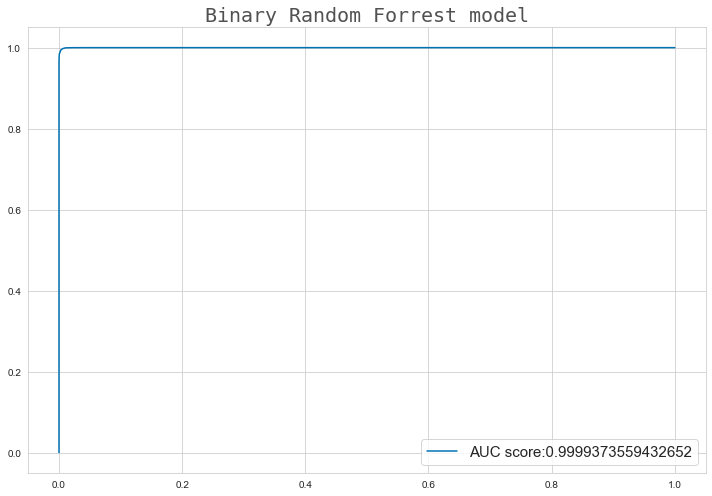

In [122]:
# Set the colour palette
sns.reset_orig()
my_palette = sns.color_palette("colorblind")
plt.style.use('seaborn-colorblind')
sns.set_style("whitegrid")


#plot 
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_proba = model4.predict_proba(X_test_BIN)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_BIN,  y_pred_proba)
auc = metrics.roc_auc_score(y_test_BIN, y_pred_proba)

f, ax = plt.subplots(figsize=(10, 7))
plt.plot(fpr,tpr,label="AUC score:"+str(auc))
plt.legend(loc=4,fontsize = 15)
ax.set_title('Binary Random Forrest model',fontsize=20, fontname="Monospace", alpha=.8)
plt.tight_layout(rect=[0, 0, 1, 1]) #tight layout
plt.savefig('Q5_plot2.png', bbox_inches='tight')
plt.show() #plot
